This notebook has been used to analyze pre-processed neuroimaging data in the article "Obesity accelerates the brain ageing process: a multimodal imaging and machine learning study". In particular, resting state fMRI-derived measures (intra- and inter-connectivity), have been used to predict age and the obesity status following a machine learning approach.

In [ ]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # this module is useful to work with numerical arrays
import pandas as pd  # this module is useful to work with tabular data
import random  # this module will be used to select random samples from a collection
import math
import scipy
from scipy import stats
import seaborn as sns
import nibabel as nib
import sklearn
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import SVR
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os  # this module will be used just to create directories in the local filesystem

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#fMRI data

In [ ]:
fmri = []
fmri_path = '/content/drive/MyDrive/SC/CCO/SUBJECTS_TS'
files_fmri = []
for subdir, dirs, files in os.walk(fmri_path):
    dirs.sort()
    if subdir[-2:] == 'AT':
        print(files[0])
        fmri.append(pd.read_csv(subdir + '/' + files[0], sep='\t', header=None))
fmri_data = np.array(fmri)

sub-CC110045.txt
sub-CC110069.txt
sub-CC110101.txt
sub-CC110187.txt
sub-CC110319.txt
sub-CC110411.txt
sub-CC112141.txt
sub-CC120049.txt
sub-CC120061.txt
sub-CC120120.txt
sub-CC120123.txt
sub-CC120166.txt
sub-CC120182.txt
sub-CC120208.txt
sub-CC120218.txt
sub-CC120234.txt
sub-CC120264.txt
sub-CC120276.txt
sub-CC120286.txt
sub-CC120309.txt
sub-CC120313.txt
sub-CC120319.txt
sub-CC120347.txt
sub-CC120462.txt
sub-CC120469.txt
sub-CC120470.txt
sub-CC120550.txt
sub-CC120640.txt
sub-CC120727.txt
sub-CC120764.txt
sub-CC120816.txt
sub-CC120987.txt
sub-CC121106.txt
sub-CC121111.txt
sub-CC121144.txt
sub-CC121158.txt
sub-CC121194.txt
sub-CC121200.txt
sub-CC121317.txt
sub-CC121397.txt
sub-CC121411.txt
sub-CC121428.txt
sub-CC121479.txt
sub-CC121685.txt
sub-CC121795.txt
sub-CC122172.txt
sub-CC122405.txt
sub-CC122620.txt
sub-CC210172.txt
sub-CC210250.txt
sub-CC210314.txt
sub-CC210422.txt
sub-CC210519.txt
sub-CC210526.txt
sub-CC210617.txt
sub-CC210657.txt
sub-CC212153.txt
sub-CC220098.txt
sub-CC220107.t

In [ ]:
corr_list = []
for sub in range(fmri_data.shape[0]):
    corr_list.append(np.corrcoef([fmri_data[sub, :, i] for i in range(fmri_data.shape[2])]))
print(len(corr_list))

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


535


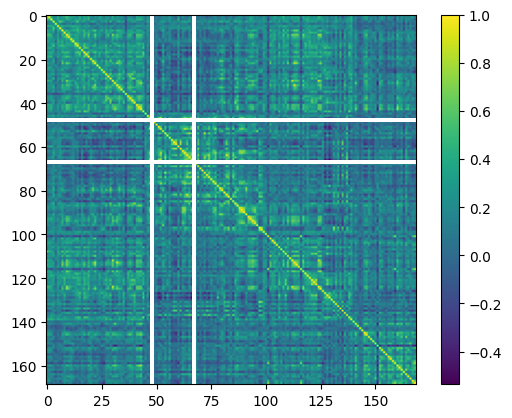

In [ ]:
plt.imshow(np.array(corr_list[399]))
plt.colorbar()

Subj 399 contains nans, strategies used are 2 (see figure above):


1.   removing the subject
2.   removing the rows and columns, corresponding to those that in subj n.399 contain nan values, in all subjects



In [ ]:
corr_list_array = np.array(corr_list)
corr_mat1 = np.delete(np.delete(corr_list_array, [48, 67], axis=1), [48, 67], axis=2)
corr_mat1.shape

(535, 167, 167)

At this moment corr_mat contains all the matrixes except from that one containing nan values (i.e., n.399), while corr_mat1 contains all matrixes without rows and columns corresponding to those that in the subj. 399 contain nan values

In [ ]:
corr_mat = corr_mat1

In [ ]:
corr_mat.shape

(535, 167, 167)

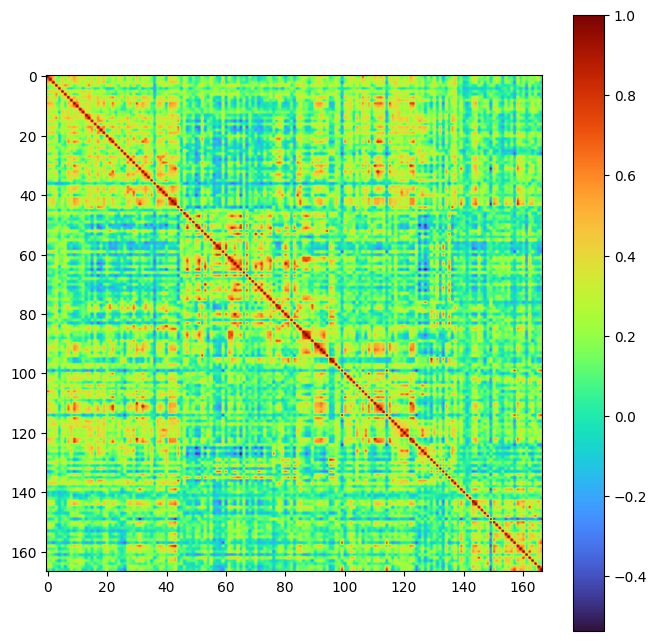

In [ ]:
fig = plt.figure(figsize=(8, 8))
chosen_mat = corr_mat[399]
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=np.min(chosen_mat), vmax=np.max(chosen_mat))
plt.colorbar()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

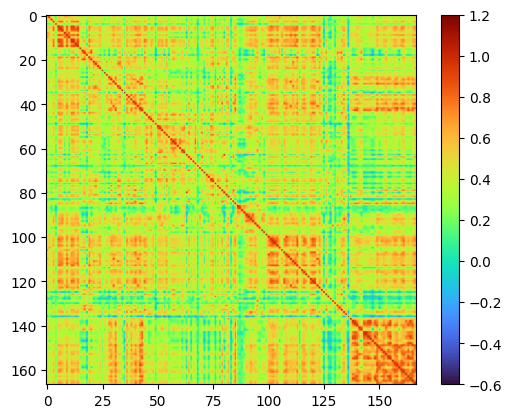

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

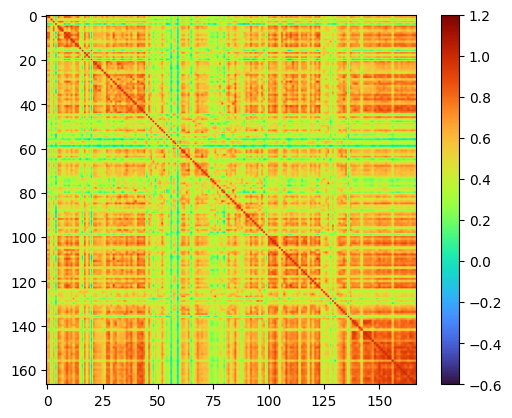

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

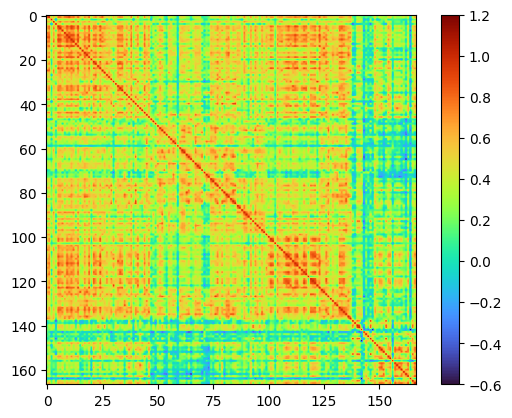

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

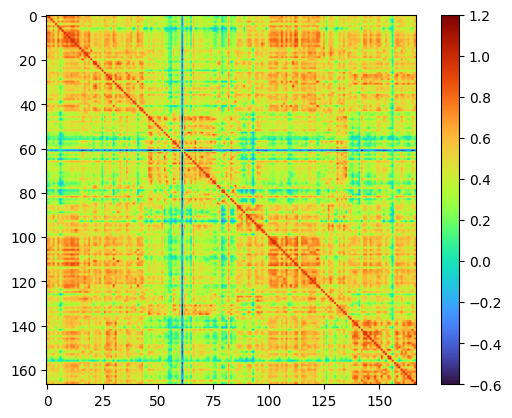

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

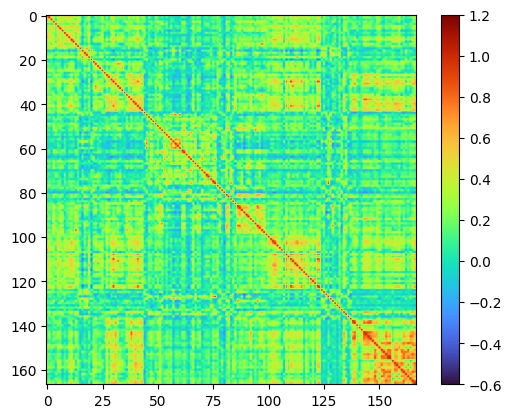

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

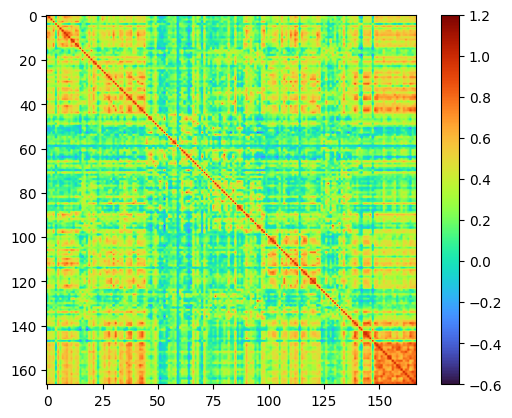

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

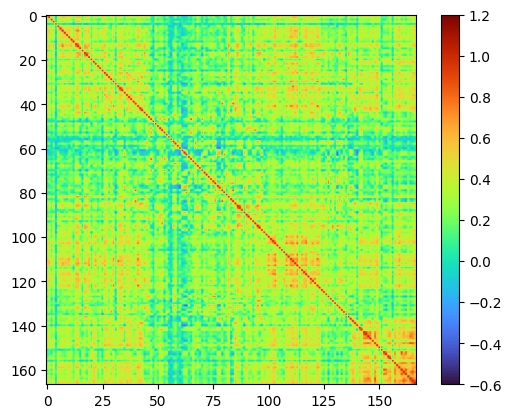

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

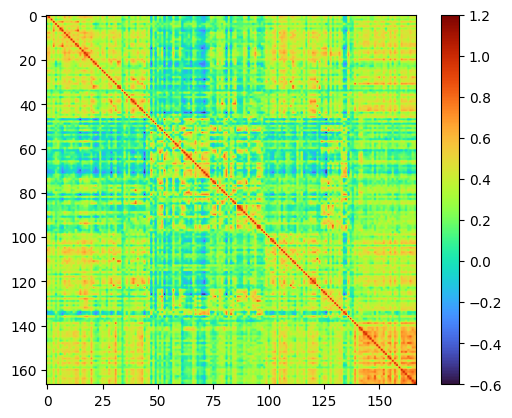

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

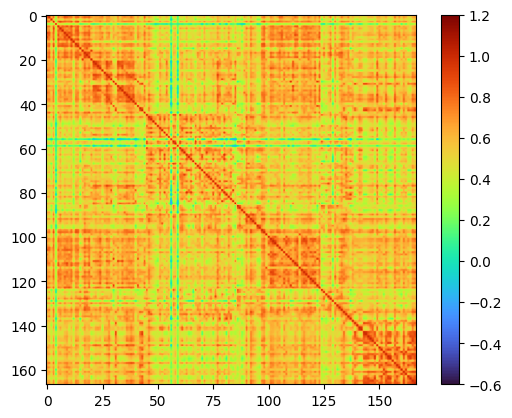

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

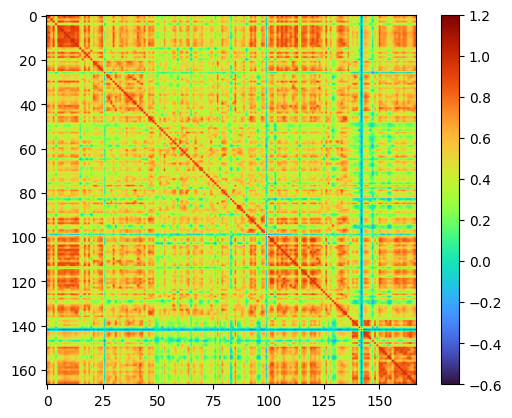

<IPython.core.display.Javascript object>

In [ ]:
from matplotlib import pyplot as plt
from google.colab import widgets

tb = widgets.TabBar([str(i + 1) for i in range(10)])
for i in range(10):
    # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i, select=(i < 3)):
        chosen_mat = corr_mat[i]
        plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.6, vmax=1.2)
        plt.colorbar()
        plt.show()


In [ ]:
mean_corr_mat = np.mean(corr_mat[:], 0)
mean_corr_mat

array([[1.        , 0.66234382, 0.43234401, ..., 0.35021772, 0.38201253,
        0.41532322],
       [0.66234382, 1.        , 0.36479527, ..., 0.32800149, 0.37147178,
        0.39409778],
       [0.43234401, 0.36479527, 1.        , ..., 0.22162099, 0.27104682,
        0.26111668],
       ...,
       [0.35021772, 0.32800149, 0.22162099, ..., 1.        , 0.67679433,
        0.62622498],
       [0.38201253, 0.37147178, 0.27104682, ..., 0.67679433, 1.        ,
        0.70438194],
       [0.41532322, 0.39409778, 0.26111668, ..., 0.62622498, 0.70438194,
        1.        ]])

In [ ]:
areas = [14, 20, 44, 73, 85, 98, 123, 137, 149]

In [ ]:
chosen_mat.shape

(167, 167)

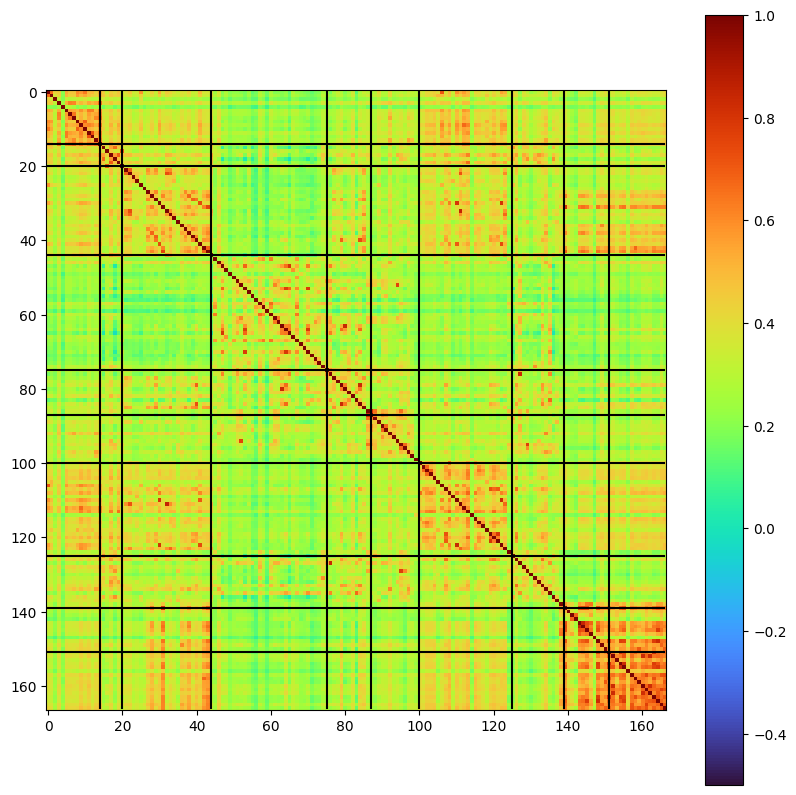

In [ ]:
fig = plt.figure(figsize=(10, 10))
chosen_mat = mean_corr_mat
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.5, vmax=1)
for area in areas:
    plt.plot([0, np.shape(chosen_mat)[1] - 1], [area, area], 'k')
    plt.plot([area, area], [0, np.shape(chosen_mat)[1] - 1], 'k')
plt.colorbar()


In [ ]:
def left_symmat(symmetrical_matrix):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, True)
        for i in range(x_matrix):
            for j in range(x_matrix):
                if j >= i:
                    true_matrix[i, j] = False
        return true_matrix

In [ ]:
def split_symmat(symmetrical_matrix):
    splitted_array = symmetrical_matrix[left_symmat(symmetrical_matrix)]
    return splitted_array

Here an example:

In [ ]:
example_split_symmat = split_symmat(corr_mat[0])
print('the 1st fc matrix is:', example_split_symmat)
print('and its shape is:', example_split_symmat.shape)

the 1st fc matrix is: [0.61416019 0.37671819 0.42510659 ... 0.64273401 0.52654879 0.73635521]
and its shape is: (13861,)


In [ ]:
subj_arrays = []
for sub in corr_mat:
    subj_arrays.append(split_symmat(sub))
subj_arrays = np.array(subj_arrays)
subj_arrays.shape

(535, 13861)

Let's check if there are NaN elements in the matrices.

In [ ]:
for i in range(len(subj_arrays)):
    for j in range(len(subj_arrays[i])):
        if np.isnan(subj_arrays[i][j]):
            print('There is a NaN in the matrix:', i)
            break

In [ ]:
for i in range(len(subj_arrays)):
    for j in range(len(subj_arrays[i])):
        if np.isnan(subj_arrays[i][j]):
            subj_arrays[i][j] = 0

In [ ]:
cent_subjs = subj_arrays - np.mean(subj_arrays)
print(subj_arrays.mean())
print(cent_subjs.mean())

0.32291020466941295
5.690370681852711e-17


## Interconnection and Intraconnection values

### Interconnection

In [ ]:
reg_coord = [0, 15, 21, 45, 74, 86, 99, 124, 138, 150]

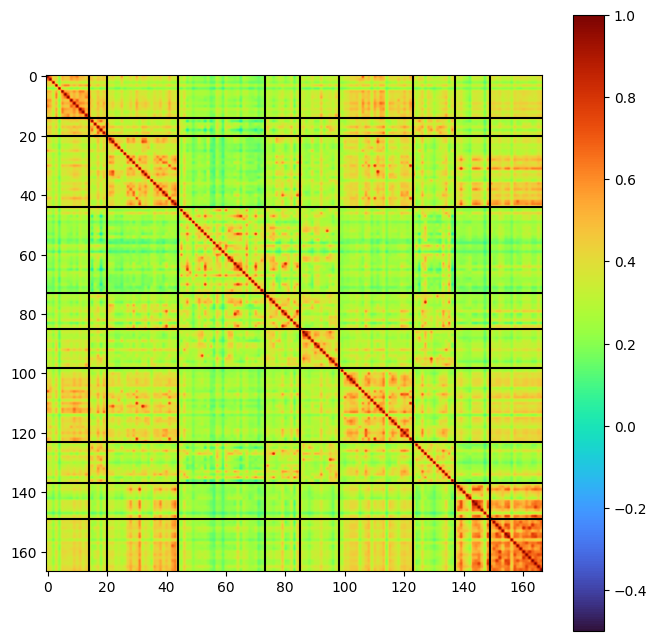

In [ ]:
fig = plt.figure(figsize=(8, 8))
chosen_mat = mean_corr_mat
plt.imshow(np.array(chosen_mat), cmap='turbo', vmin=-0.5, vmax=1)
for n_area in range(len(areas)):
    plt.plot([0, 166], [areas[n_area], areas[n_area]], 'k')
    plt.plot([areas[n_area], areas[n_area]], [0, 166], 'k')
plt.colorbar()


The following functions extract inter- and intra-connectivity arrays from the full symmetrical connectivity matrix.

In [ ]:
def intercon_mat(symmetrical_matrix, areas_coordinates):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, False)
    for i in range(1, len(areas_coordinates)):
        true_matrix[areas_coordinates[i]:, areas_coordinates[i - 1]:areas_coordinates[i]] = True
    return true_matrix

In [ ]:
corr_mat[0][intercon_mat(corr_mat[0], reg_coord)].shape

(12322,)

In [ ]:
def intracon_mat(symmetrical_matrix, areas_coordinates):
    x_matrix, y_matrix = symmetrical_matrix.shape
    if x_matrix != y_matrix:
        raise TypeError('ERROR: the input is not a square matrix!')
    else:
        true_matrix = np.full(symmetrical_matrix.shape, False)
    return (left_symmat(symmetrical_matrix) & ~intercon_mat(symmetrical_matrix, areas_coordinates))

In [ ]:
intercon_values = [corr_mat[i][intercon_mat(corr_mat[i], reg_coord)] for i in range(corr_mat.shape[0])]
intercon_values = np.array(intercon_values)
intracon_values = [corr_mat[i][intracon_mat(corr_mat[i], reg_coord)] for i in range(corr_mat.shape[0])]
intracon_values = np.array(intracon_values)

In [ ]:
print(intercon_values.shape)
print(intracon_values.shape)

(535, 12322)
(535, 1539)


# Data organization

Other variables are stored in the next dataframe:

In [ ]:
data = pd.read_excel('drive/MyDrive/SC/CCO/For_Marco.xlsx')
data

ID    Age  Handedness  Education  Sex  BP_Systolic  BP_Diastolic  \
0    CC110045  24.50         100          4    1         90.5          63.5   
1    CC110069  28.67         -58          4    1         94.5          61.5   
2    CC110101  23.33          63          4    0        108.5          63.0   
3    CC110187  25.25        -100          4    1        116.0          71.5   
4    CC110319  28.42         100          4    1        104.0          50.5   
..        ...    ...         ...        ...  ...          ...           ...   
530  CC722542  79.33         100          4    0        149.5          72.0   
531  CC722651  79.83         100          1    1        122.5          63.5   
532  CC722891  84.42          89          0    1        136.5          73.0   
533  CC723197  80.08         100          4    1        186.0          94.0   
534  CC723395  86.08          90          3    1        102.0          50.5   

     Heart_Rate    BMI  MMSE  Group  Unnamed: 11 Unnamed: 12  \
0          61.5  21.66    30      1          NaN         Sex   
1          62.0  22.09    28      1          NaN       Group   
2          78.5  20.39    30      1          NaN         NaN   
3          79.0  21.52    30      1          NaN         NaN   
4          48.5  24.23    30      1          NaN         NaN   
..          ...    ...   ...    ...          ...         ...   
530        51.0  30.96    30      3          NaN         NaN   
531        60.5  22.46    28      1          NaN         NaN   
532        76.0  26.11    26      2          NaN         NaN   
533        64.0  22.72    29      1          NaN         NaN   
534        68.0  30.85    28      3          NaN         NaN   

          Unnamed: 13 Unnamed: 14            Unnamed: 15  Unnamed: 16  \
0              0=Male    1=Female                    NaN          NaN   
1    1= Normal weight         NaN  2=Slightly overweight          NaN   
2                 NaN         NaN                    NaN          NaN   
3                 NaN         NaN                    NaN          NaN   
4                 NaN         NaN                    NaN          NaN   
..                ...         ...                    ...          ...   
530               NaN         NaN                    NaN          NaN   
531               NaN         NaN                    NaN          NaN   
532               NaN         NaN                    NaN          NaN   
533               NaN         NaN                    NaN          NaN   
534               NaN         NaN                    NaN          NaN   

    Unnamed: 17  
0           NaN  
1       3=Obese  
2           NaN  
3           NaN  
4           NaN  
..          ...  
530         NaN  
531         NaN  
532         NaN  
533         NaN  
534         NaN  

[535 rows x 18 columns]

The sample will be split in 3 groups:


1.   Normal weight
2.   Sligtly overweight
3.   Obese

Only the first and the last ones will be taken into account within this study.



In [ ]:
norm_weight_ss = data[data['Group'] == 1]
slight_overweight_ss = data[data['Group'] == 2]
obese_ss = data[data['Group'] == 3]

print('there are', len(norm_weight_ss), 'normal weight subjects ')
print('there are', len(slight_overweight_ss), 'slight overweight subjects ')
print('there are', len(obese_ss), 'obese subjects ')

there are 261 normal weight subjects 
there are 183 slight overweight subjects 
there are 91 obese subjects 


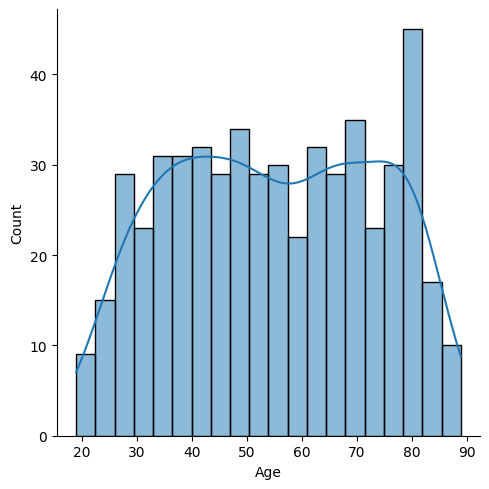

In [ ]:
sns.displot(data=data, x='Age', bins=20, kde=True)

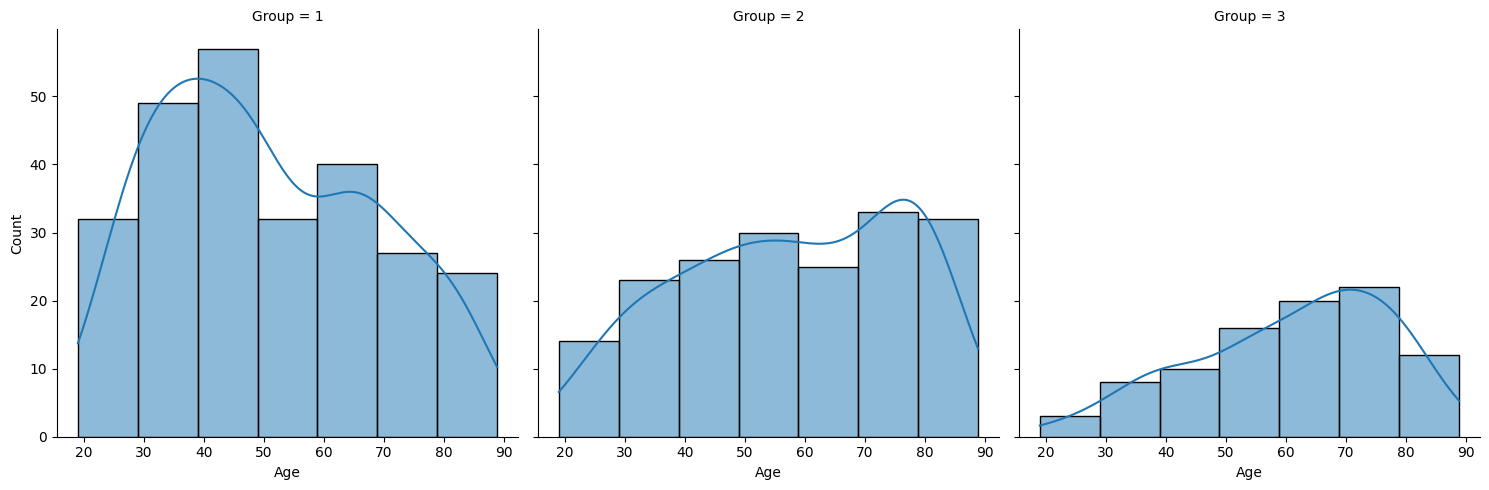

In [ ]:
sns.displot(data=data, x='Age', col='Group', bins=7, kde=True)

#OBESE-MATCHED SPLIT

In this section the obese group (O) and a control sample of norm-weight (NWc) subjects matched by age, gender and education with O will be used as test groups. The remaining norm-weighted subjects and the entire set of slight overweigt individuals (SOW) will be used for training the model. Therefore, in this section an out-of-sample prediction is conducted.

In [ ]:
#MATCH AGE GENDER & EDUCATION
obese_ss = data[data.Group == 3]
ob_indexes = []
match_indexes = []
norm_sample = norm_weight_ss
ob_excluded = []
for i in range(obese_ss.shape[0]):
    norm_match = np.abs(norm_sample[(norm_sample.Sex == obese_ss.iloc[i]['Sex']) &
                                    (np.abs(norm_sample.Education - obese_ss.iloc[i]['Education']) <= 1)].Age -
                        obese_ss.iloc[i]['Age']).sort_values()
    if np.abs(norm_match.iloc[0]) <= 5:
        match_ind = norm_match.index[0]
        ob_indexes.append(i)
        match_indexes.append(match_ind)
        norm_sample = norm_sample.drop(match_ind)
    else:
        ob_excluded.append(i)
norm_test = norm_weight_ss.loc[match_indexes]
obese_ss_df = obese_ss
excluded_obese = obese_ss.iloc[ob_excluded]
print(obese_ss_df.shape)
obese_ss = obese_ss.iloc[ob_indexes]

(91, 18)


In [ ]:
data[data.Group == 2].index

Index([  6,   9,  17,  19,  20,  22,  26,  29,  30,  32,
       ...
       511, 512, 513, 514, 517, 518, 519, 520, 528, 532],
      dtype='int64', length=183)

In [ ]:
norm_train = norm_weight_ss.drop(index=norm_test.index)
norm_train

ID    Age  Handedness  Education  Sex  BP_Systolic  BP_Diastolic  \
0    CC110045  24.50         100          4    1         90.5          63.5   
1    CC110069  28.67         -58          4    1         94.5          61.5   
2    CC110101  23.33          63          4    0        108.5          63.0   
4    CC110319  28.42         100          4    1        104.0          50.5   
5    CC110411  25.25         100          4    0         92.5          54.0   
..        ...    ...         ...        ...  ...          ...           ...   
507  CC721107  79.33         100          4    1        128.0          67.5   
516  CC721434  84.92         100          0    0        113.5          73.0   
524  CC721888  78.92          62          4    1        134.0          75.0   
529  CC722536  80.00         -56          4    1        134.0          59.0   
533  CC723197  80.08         100          4    1        186.0          94.0   

     Heart_Rate    BMI  MMSE  Group  Unnamed: 11 Unnamed: 12  \
0          61.5  21.66    30      1          NaN         Sex   
1          62.0  22.09    28      1          NaN       Group   
2          78.5  20.39    30      1          NaN         NaN   
4          48.5  24.23    30      1          NaN         NaN   
5          61.5  19.40    30      1          NaN         NaN   
..          ...    ...   ...    ...          ...         ...   
507        56.0  24.36    28      1          NaN         NaN   
516        98.5  21.17    25      1          NaN         NaN   
524        77.5  23.01    27      1          NaN         NaN   
529        68.0  20.48    30      1          NaN         NaN   
533        64.0  22.72    29      1          NaN         NaN   

          Unnamed: 13 Unnamed: 14            Unnamed: 15  Unnamed: 16  \
0              0=Male    1=Female                    NaN          NaN   
1    1= Normal weight         NaN  2=Slightly overweight          NaN   
2                 NaN         NaN                    NaN          NaN   
4                 NaN         NaN                    NaN          NaN   
5                 NaN         NaN                    NaN          NaN   
..                ...         ...                    ...          ...   
507               NaN         NaN                    NaN          NaN   
516               NaN         NaN                    NaN          NaN   
524               NaN         NaN                    NaN          NaN   
529               NaN         NaN                    NaN          NaN   
533               NaN         NaN                    NaN          NaN   

    Unnamed: 17  
0           NaN  
1       3=Obese  
2           NaN  
4           NaN  
5           NaN  
..          ...  
507         NaN  
516         NaN  
524         NaN  
529         NaN  
533         NaN  

[178 rows x 18 columns]

In [ ]:
n_bins = 10
bins_sample = pd.cut(data.Age, bins=n_bins, retbins=True)[1]
bins_sample

array([18.93008, 25.992  , 32.984  , 39.976  , 46.968  , 53.96   ,
       60.952  , 67.944  , 74.936  , 81.928  , 88.92   ])

(0.0, 20.0)

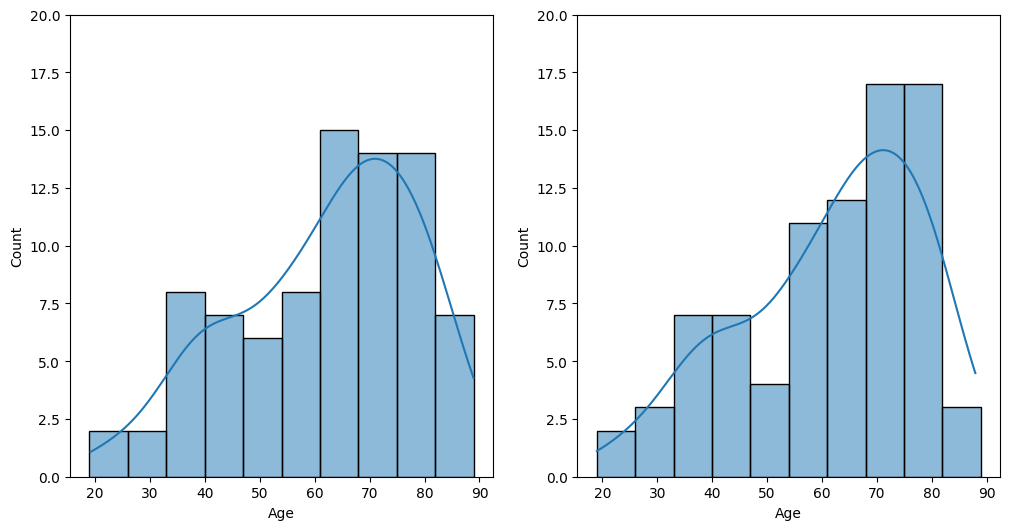

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
sns.histplot(data=norm_test, x='Age', bins=bins_sample, kde=True, ax=axes[0])
sns.histplot(data=obese_ss, x='Age', bins=bins_sample, kde=True, ax=axes[1])
axes[0].set_ylim([0, 20])
axes[1].set_ylim([0, 20])

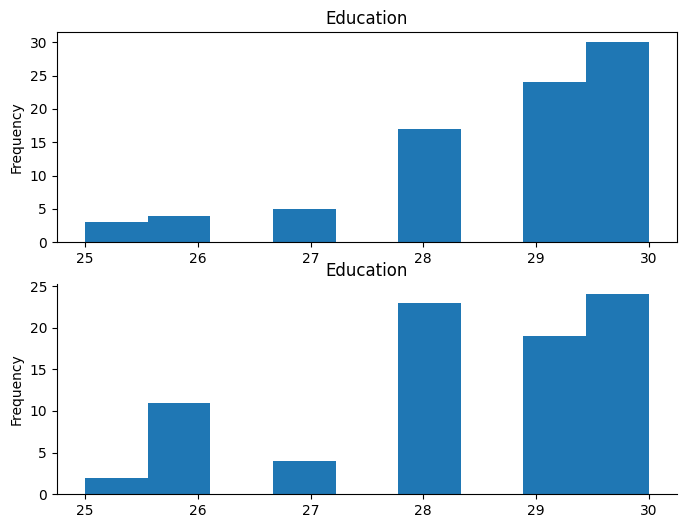

In [ ]:
fig, axes = plt.subplots(2, figsize=(8, 6))
norm_test['MMSE'].plot(kind='hist', bins=9, title='Education', ax=axes[0])
obese_ss['MMSE'].plot(kind='hist', bins=9, title='Education', ax=axes[1])
plt.gca().spines[['top', 'right', ]].set_visible(False)

In [ ]:
stats.ttest_ind(norm_test.MMSE, obese_ss.MMSE)

TtestResult(statistic=1.5195138577344487, pvalue=0.13055873030279086, df=164.0)

In [ ]:
#fig, axes = plt.subplots(ncols=2, figsize=(12,7))
#norm_test.plot(kind='scatter', x='index', y='Age', s=32, alpha=.8, ax= axes[0])
#obese_ss.plot(kind='scatter', x='index', y='Age', s=32, alpha=.8, ax = axes[1])
#plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
tt_age = stats.ttest_ind(norm_test.Age, obese_ss.Age)
print(tt_age.pvalue)

0.9169471865162


## Data Used

In the next lines of code it is possible to select the type of data (full connectivity matrix, inter- or intra-connectivity measures)

In [ ]:
type_data = [subj_arrays, intercon_values, intracon_values]

In [ ]:
type_data[0].shape

(535, 13861)

In [ ]:
data_used = type_data[2]  #0=tot; 1=inter; 2=intra
#data_used.shape

## Model selection


In the following section, we will tune an Elastic Net model using a grid search. The tuning is done on the following hyperparameters:


*   Number of Principal Components
*   Alpha
*   L1 ratio



In [ ]:
nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index))
nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index, excluded_obese.index))
train_sample = data_used[nw_sow_train_index]
pca = PCA(n_components=.95, svd_solver='auto')
encoded_samples_reduced_PCA_0 = pca.fit_transform(train_sample)
train_age = data.Age[nw_sow_train_index]
y_train_0 = (train_age - np.mean(train_age)) / np.std(train_age)
max_n_comp = encoded_samples_reduced_PCA_0.shape[1]

In [ ]:
nw_sow_train_index.shape

(369,)

In [ ]:
max_n_comp

215

In [ ]:
elastic_net = ElasticNet()
n_components = np.arange(60, max_n_comp + 4, 5)
n_components = [185]
l1_ratio = [0.001, 0.25, 0.5]
alpha = np.logspace(-5, 5, 100)
param_grid = {  # adjust based on the number of features
    'alpha': alpha,
    'l1_ratio': l1_ratio
}
best_score = -100
scores = []
for comp in n_components:
    x_train_0 = (encoded_samples_reduced_PCA_0[:, 0:comp] - np.mean(encoded_samples_reduced_PCA_0[:, 0:comp])) / np.std(
        encoded_samples_reduced_PCA_0[:, 0:comp])
    # Set up GridSearchCV
    train_age_cat = pd.cut(y_train_0, bins=10, labels=range(10))
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
    kf.get_n_splits(x_train_0)
    grid_search = GridSearchCV(elastic_net, param_grid, cv=kf.split(x_train_0, train_age_cat), scoring='r2', n_jobs=-1)
    # Fit the model
    grid_search.fit(x_train_0, y_train_0)
    # Best parameters and model
    if grid_search.best_score_ >= best_score:
        best_score = grid_search.best_score_
        best_n_components = comp
        best_parameters = grid_search.best_params_

print("Best cross-validation score: ", best_score)
print("best number of components: ", best_n_components)
print("best parameters:", best_parameters)

Best cross-validation score:  0.5703729058969986
best number of components:  185
best parameters: {'alpha': 0.3511191734215127, 'l1_ratio': 0.001}


In [ ]:
n_comp = best_n_components

After selecting the hyperparameters, the test datasets were standardized. The Elastic Net model was then trained on the training set using these hyperparameters and subsequently evaluated on the test datasets.

In [ ]:
nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index))
#nw_sow_train_index = np.concatenate((norm_train.index, slight_overweight_ss.index, excluded_obese.index))
train_sample = data_used[nw_sow_train_index]
pca = PCA(n_components=n_comp, svd_solver='auto')
encoded_samples_reduced_PCA = pca.fit_transform(train_sample)
print('pca components shape:', encoded_samples_reduced_PCA.shape)
x_test = (pca.transform(data_used[norm_test.index]) - np.mean(encoded_samples_reduced_PCA)) / np.std(
    encoded_samples_reduced_PCA)
x_train = (encoded_samples_reduced_PCA - np.mean(encoded_samples_reduced_PCA)) / np.std(encoded_samples_reduced_PCA)
print(x_train.shape)
print(x_test.shape)

train_age = data.Age[nw_sow_train_index]
y_test = (data.Age[norm_test.index] - np.mean(train_age)) / np.std(train_age)
y_train = (train_age - np.mean(train_age)) / np.std(train_age)
print(y_train.shape)
print(y_test.shape)
ob_age = obese_ss.Age
norm_ob_age = (ob_age - np.mean(train_age)) / np.std(train_age)

pca components shape: (361, 185)
(361, 185)
(83, 185)
(361,)
(83,)


In [ ]:
norm_test.index

Index([ 10,  40,   3,  96,  55,  93, 100, 103, 126, 107, 149, 212, 195, 204,
       173, 203, 214, 175, 161, 274, 270, 225, 256, 251, 290, 269, 281, 235,
       292, 252, 289, 316, 359, 326, 337, 310, 349, 365, 332, 360, 374, 314,
       354, 357, 329, 347, 370, 308, 328, 436, 420, 386, 398, 391, 430, 425,
       459, 488, 444, 414, 531, 383, 400, 442, 450, 453, 421, 439, 403, 451,
       496, 487, 521, 429, 503, 476, 478, 522, 502, 525, 499, 485, 527],
      dtype='int64')

In [ ]:
print(x_train.mean())
print(x_train.std())

-3.4045620340380635e-18
1.0


In [ ]:
el_reg = ElasticNet(alpha=best_parameters['alpha'], l1_ratio=best_parameters['l1_ratio'], random_state=10)
el_reg.fit(x_train, y_train)

ElasticNet(alpha=0.3511191734215127, l1_ratio=0.001, random_state=10)

In [ ]:
split_test = True
normal_setting = True

In [ ]:
dataframes = []
comparisons = [[y_train, el_reg.predict(x_train)]]
print('score of the model computed on the train dataset:', el_reg.score(x_train, y_train))
comparisons.append([y_test, el_reg.predict(x_test)])
print('score of the model computed on the test dataset:', el_reg.score(x_test, y_test))
for comp in comparisons:
    comp[0] = comp[0] * np.std(train_age) + np.mean(train_age)
    comp[1] = comp[1] * np.std(train_age) + np.mean(train_age)
print('number of comparisons (true age vs prediction):', len(comparisons))
for comp, sample in zip(comparisons, ['train', 'test']):
    print('mean absolute error (in years) of the model predictions on the', sample, 'dataset',
          np.mean(np.abs(comp[0] - comp[1])))
    df = pd.DataFrame({sample + ' true age': comp[0], 'prediction': comp[1], 'error': np.abs(comp[1] - comp[0])})
    dataframes.append(df)
    print(df)

score of the model computed on the train dataset: 0.7830100728050402
score of the model computed on the test dataset: 0.41049094919181184
number of comparisons (true age vs prediction): 2
mean absolute error (in years) of the model predictions on the train dataset 6.955593968066316
     train true age  prediction      error
0             24.50   31.293731   6.793731
1             28.67   31.511235   2.841235
2             23.33   38.584148  15.254148
4             28.42   35.906590   7.486590
5             25.25   40.208058  14.958058
..              ...         ...        ...
518           79.25   73.292114   5.957886
519           81.83   61.681848  20.148152
520           80.75   79.833163   0.916837
528           79.42   69.718230   9.701770
532           84.42   65.376102  19.043898

[361 rows x 3 columns]
mean absolute error (in years) of the model predictions on the test dataset 10.049787595032036
     test true age  prediction      error
10           19.17   43.165023  23.99502

In [ ]:
train_df = dataframes[0]
train_df['error'] = train_df['prediction'] - train_df['train true age']
test_df = dataframes[1]
test_df['error'] = test_df['prediction'] - test_df['test true age']

In [ ]:
test_df['error'].mean()

-6.146521487484858

In [ ]:
test_df['error'].std()

10.95565693808813

In [ ]:
norm_ob_values = (pca.transform(data_used[obese_ss.index]) - np.mean(encoded_samples_reduced_PCA)) / np.std(
    encoded_samples_reduced_PCA)
norm_ob_values.shape

(83, 185)

In [ ]:
ob_predictions = (el_reg.predict(norm_ob_values) * np.std(train_age)) + train_age.mean()

In [ ]:
error_ob = ob_predictions - ob_age
error_ob

23     29.837804
37      7.242662
38     30.960457
62     -1.985827
66      9.467893
         ...    
515   -19.463160
523    -6.928188
526    -8.605039
530   -14.352846
534   -30.154091
Name: Age, Length: 83, dtype: float64

In [ ]:
error_ob.mean()

-2.8976368968815907

In [ ]:
error_ob.std()

11.597529563224597

In [ ]:
ob_score = el_reg.score(norm_ob_values, norm_ob_age)
print(ob_score)
abs_err_ob = np.abs(error_ob)
mae_ob = abs_err_ob.mean()
print(mae_ob)

0.4587036732055375
9.198406430701306


### stats

In [ ]:
error_ob.mean() - test_df['error'].mean()

3.248884590603267

In [ ]:
err_nw_test = test_df['error']
tt_ob = stats.ttest_ind(error_ob, err_nw_test, equal_var=False)
print('norm test and obese:', tt_ob)

norm test and obese: TtestResult(statistic=1.8552592270737405, pvalue=0.06536001163615077, df=163.47121406155568)


In [ ]:
norm_ss_df = dataframes[0].rename(columns={'train true age': "true age", 'error': "absolute error"})
norm_ss_df['error'] = (norm_ss_df['prediction'] - norm_ss_df['true age']).values
norm_ss_df['group'] = np.repeat('TR', len(norm_ss_df))
norm_ss_df

true age  prediction  absolute error      error group
0       24.50   31.293731        6.793731   6.793731    TR
1       28.67   31.511235        2.841235   2.841235    TR
2       23.33   38.584148       15.254148  15.254148    TR
4       28.42   35.906590        7.486590   7.486590    TR
5       25.25   40.208058       14.958058  14.958058    TR
..        ...         ...             ...        ...   ...
518     79.25   73.292114       -5.957886  -5.957886    TR
519     81.83   61.681848      -20.148152 -20.148152    TR
520     80.75   79.833163       -0.916837  -0.916837    TR
528     79.42   69.718230       -9.701770  -9.701770    TR
532     84.42   65.376102      -19.043898 -19.043898    TR

[361 rows x 5 columns]

In [ ]:
test_ss_df = test_df.rename(columns={'test true age': "true age"})
test_ss_df['group'] = np.repeat('NWc', len(test_df))
test_ss_df
err_pred_test = test_ss_df['error']
std_test = pd.DataFrame({'true age': test_ss_df['true age'], 'error': test_ss_df['error'],
                         'z_err': (err_pred_test - np.mean(err_pred_test)) / np.std(err_pred_test),
                         'group': np.repeat('NW', len(ob_age))})

In [ ]:
ob_df = pd.DataFrame(
    {'true age': ob_age, 'prediction': ob_predictions, 'absolute error': np.abs(error_ob), 'error': error_ob,
     'group': np.repeat('O', len(ob_age))})
tot_ss_df = pd.concat([norm_ss_df, ob_df], ignore_index=True)
std_ob = pd.DataFrame(
    {'true age': ob_age, 'error': error_ob, 'z_err': (ob_df['error'] - np.mean(err_pred_test)) / np.std(err_pred_test),
     'group': np.repeat('O', len(ob_age))})
tot_ss_df = pd.concat([norm_ss_df, ob_df, test_ss_df], ignore_index=True)
tot_std = pd.concat([std_test, std_ob], ignore_index=True)

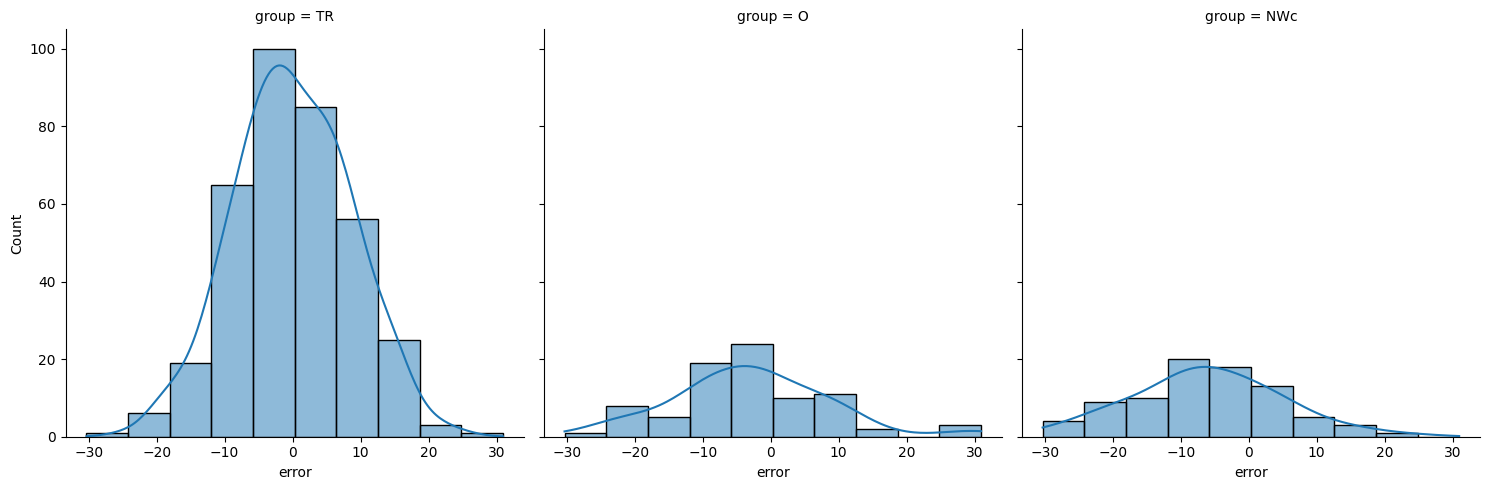

In [ ]:
sns.displot(data=tot_ss_df, x='error', col='group', bins=10, kde=True)

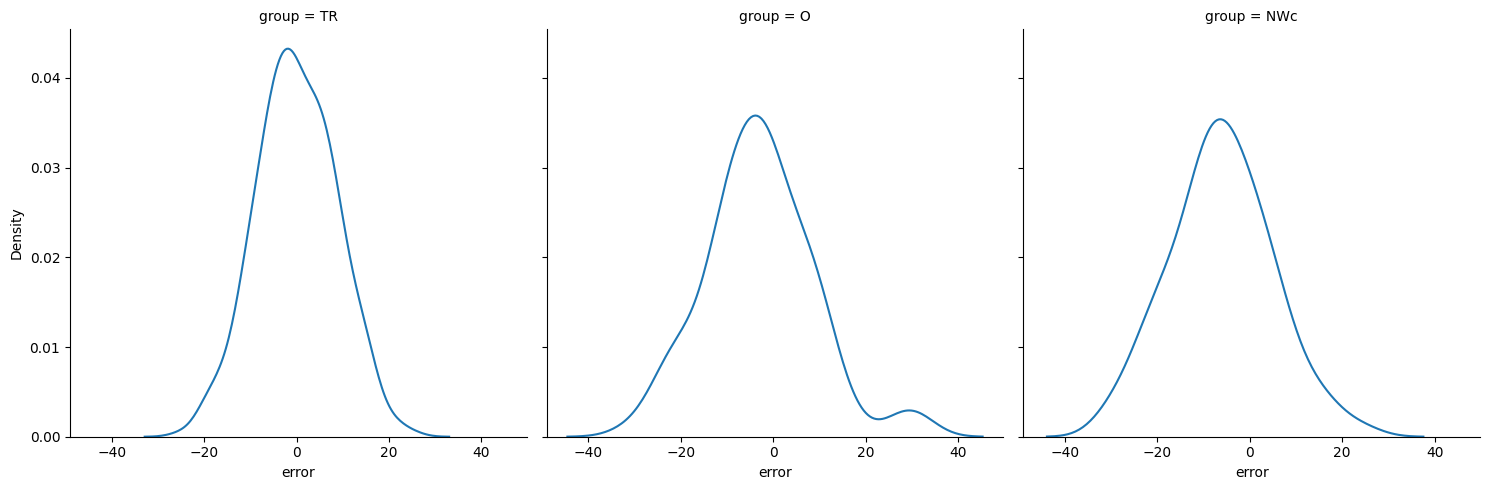

In [ ]:
sns.displot(data=tot_ss_df, x='error', col='group', kind='kde', common_norm=False)

In [ ]:
fig7 = px.scatter(tot_ss_df, x='true age', y='prediction', labels={'x': 'true age', 'y': 'prediction'}, height=600,
                  facet_col='group')
trace = go.Scatter(x=[18, 90], y=[18, 90], mode='lines', line_color='red', name='optimal prediction')
trace.update(showlegend=False)
fig7.add_trace(trace, row='all', col='all')
fig7.update_traces(selector=-1, showlegend=True)
fig7.update_xaxes(showgrid=False)
fig7.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig7.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig7.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig7.show()

In [ ]:
fig6 = px.scatter(tot_ss_df, x='true age', y='error', labels={'x': 'true age', 'y': 'prediction error'},
                  trendline="ols", height=600, facet_col='group')
#trace = go.Scatter(x=[18,100],y=[0,0], mode='lines', line_color='black', name='no prediction error')
#trace.update(showlegend=False)
#fig6.add_trace(trace, row='all', col='all')
#fig6.update_traces(selector=-1, showlegend=True)
fig6.show()

In [ ]:
fig6 = px.scatter(tot_std, x='true age', y='z_err', labels={'x': 'true age', 'y': 'z (prediction error)'},
                  trendline="ols", height=600, facet_col='group')
fig6.update_traces(selector=-1, showlegend=True)
fig6.update_xaxes(showgrid=False)
fig6.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig6.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig6.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig6.show()

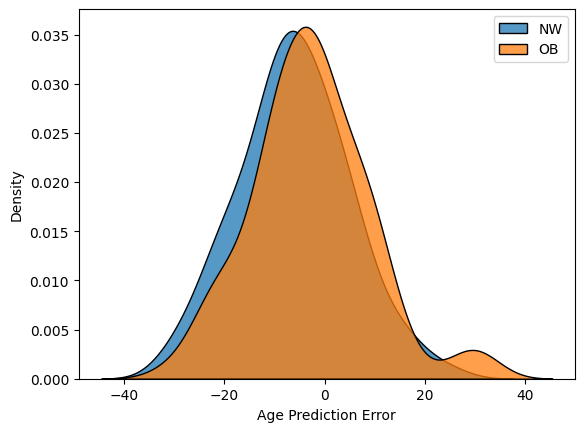

In [ ]:
kd1 = sns.kdeplot(test_ss_df, x='error', multiple='stack', label='NW')
kd2 = sns.kdeplot(ob_df, x='error', multiple='stack', label='OB')
plt.xlabel('Age Prediction Error')
plt.legend()

(-40.0, 40.0)

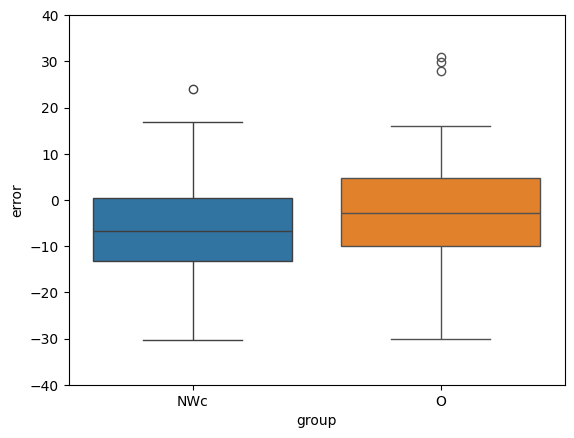

In [ ]:
sns.boxplot(data=test_ss_df, x='group', y='error')
sns.boxplot(data=ob_df, x='group', y='error')
plt.ylim(-40, 40)

In [ ]:
bins = [18, 40, 60, 90]

<Figure size 1800x500 with 0 Axes>

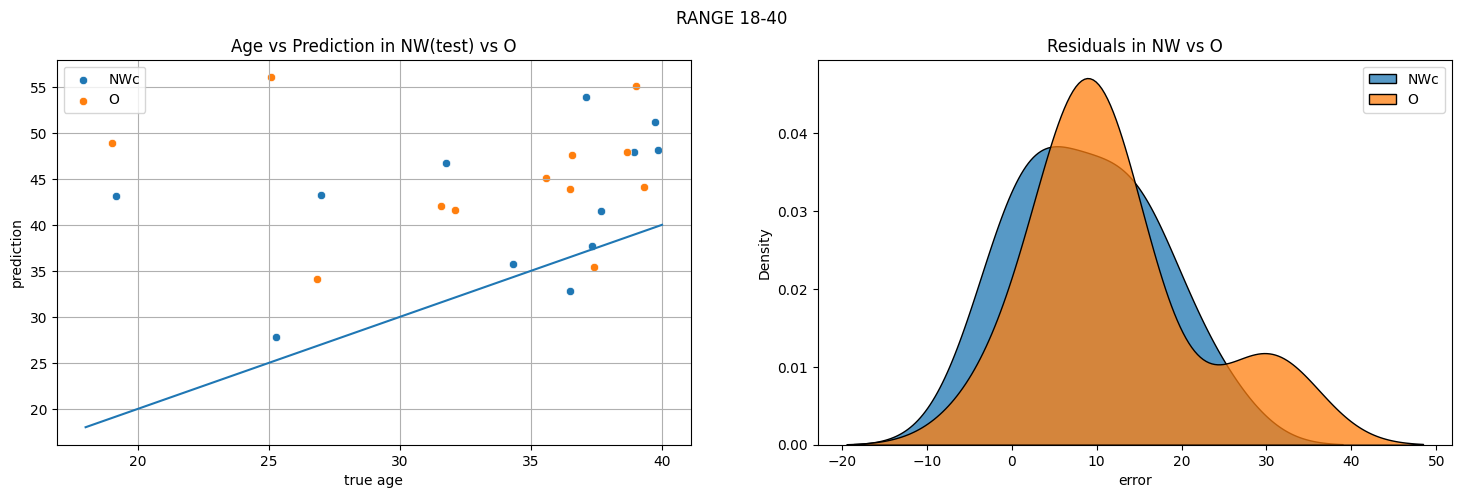

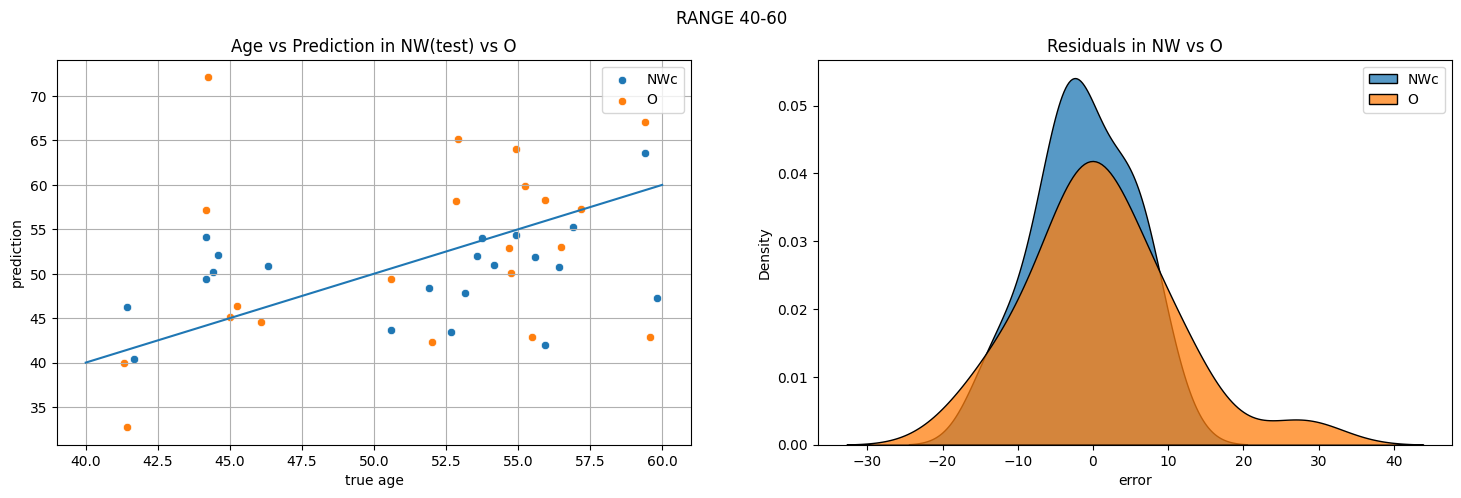

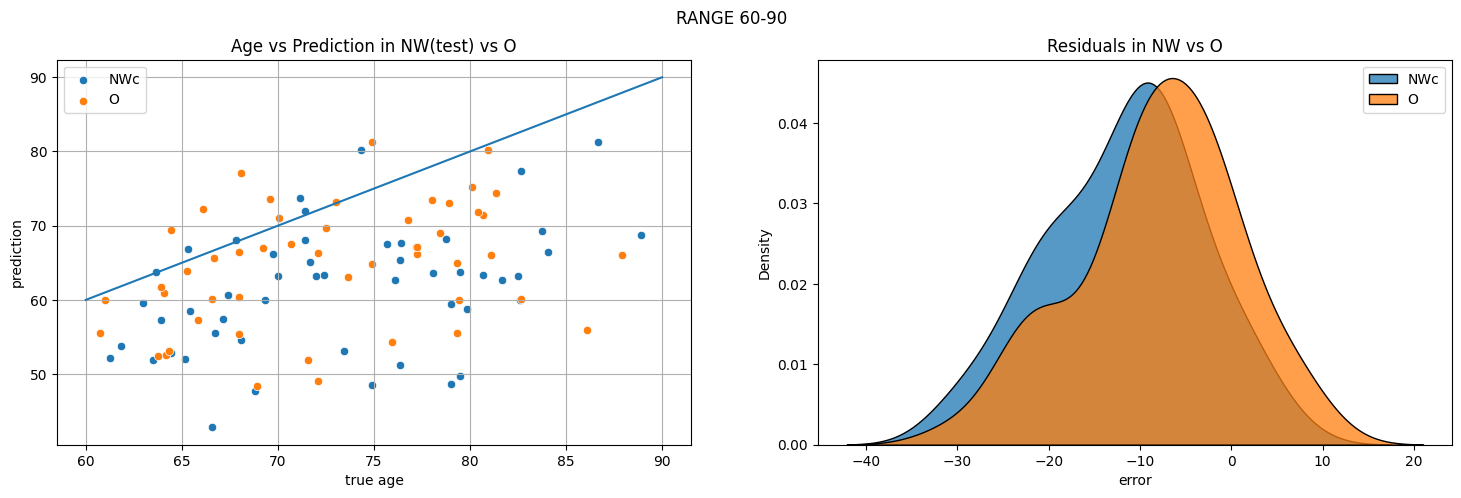

In [ ]:
fig11 = plt.figure(layout='constrained', figsize=(18, 5))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id], axes = plt.subplots(ncols=2, figsize=(18, 5))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.scatterplot(test_bin_df, x='true age', y='prediction', ax=axes[0], label='NWc')
    sc2 = sns.scatterplot(ob_bin, x='true age', y='prediction', ax=axes[0], label='O')
    sns.lineplot(x=[bins[bin_id], bins[bin_id + 1]], y=[bins[bin_id], bins[bin_id + 1]], ax=axes[0])
    kd1 = sns.kdeplot(test_bin_df, x='error', ax=axes[1], multiple='stack', label='NWc')
    kd2 = sns.kdeplot(ob_bin, x='error', ax=axes[1], multiple='stack', label='O')
    axes[0].title.set_text('Age vs Prediction in NW(test) vs O')
    axes[1].title.set_text('Residuals in NW vs O')
    axes[0].legend()
    axes[1].legend()
    axes[0].grid()

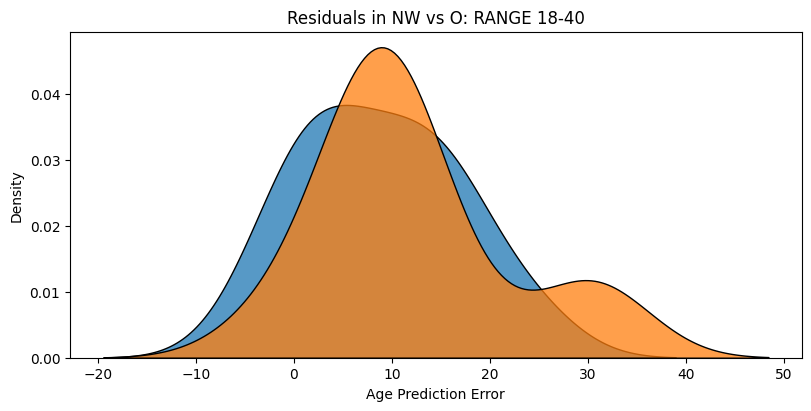

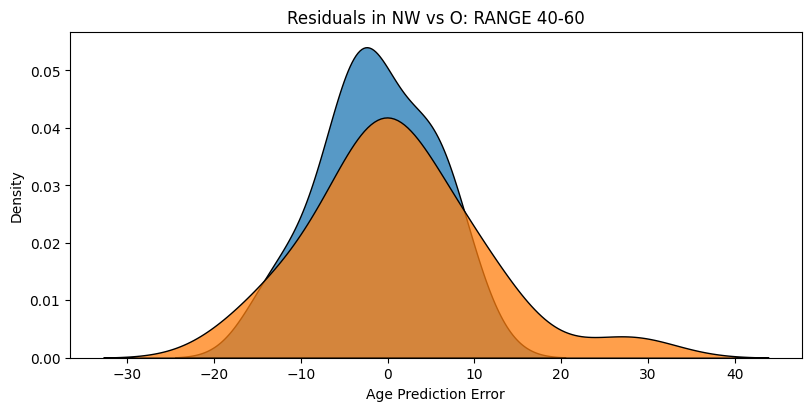

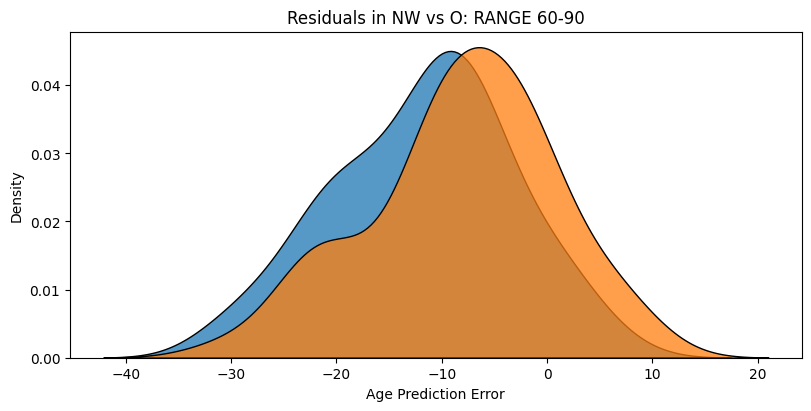

In [ ]:

for bin_id in range(len(bins) - 1):
    plt.figure(layout='constrained', figsize=(8, 4))
    plt.title('Residuals in NW vs O: RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(test_bin_df, x='error', multiple='stack', label='NWc')
    kd2 = sns.kdeplot(ob_bin, x='error', multiple='stack', label='O')
    plt.xlabel('Age Prediction Error')
    plt.show()

In [ ]:
intervals = []
small_df = [test_ss_df, ob_df]
dataf_means = [[], []]
errors_df = [[], []]
std_devs = [[], [], []]
for bin_id in range(len(bins) - 1):
    intervals.append(str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    for dfi in range(len(small_df)):
        dataf_bin = small_df[dfi]
        dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
        errors_df[dfi].append(dfi_bin['error'].values)
        dataf_means[dfi].append(dfi_bin['error'].mean())
        std_devs[dfi].append(dfi_bin['error'].std())
print(intervals)
print(dataf_means)
print(std_devs)

['18-40', '40-60', '60-90']
[[8.767890449728391, -1.2768513966977664, -11.771241790546615], [12.005516611872613, 1.0496950415083806, -8.132273153106388]]
[[8.20280710445796, 6.447623481803229, 8.477395327838414], [9.576627317530999, 9.808353888659655, 8.72924506866787], []]


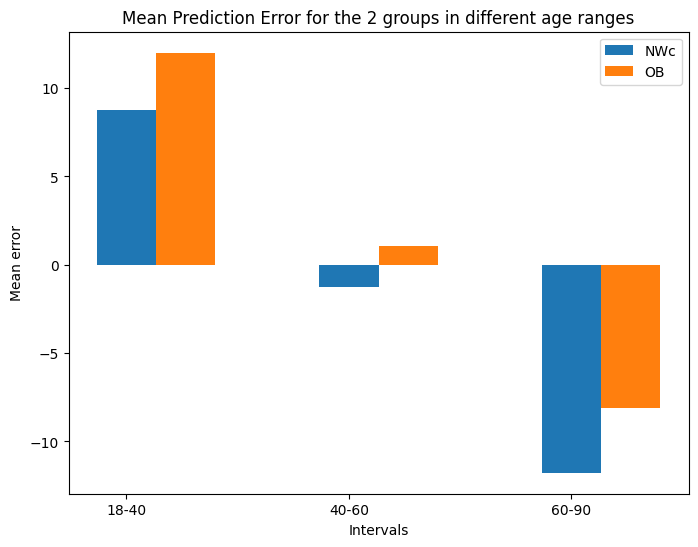

In [ ]:
barfig = plt.figure(figsize=(8, 6))
labels_df = ['NWc', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    plt.bar(inter + lab * 0.8, dataf_means[lab], label=labels_df[lab])
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

In [ ]:
for bin_i in range(len(errors_df[0])):
    print('#### BIN [', bins[bin_i], '-', bins[bin_i + 1], '] ####')
    print('####### t-test #######')
    ob_nw_tt = stats.ttest_ind(errors_df[1][bin_i], errors_df[0][bin_i], equal_var=False)
    print('norm test and obese:', ob_nw_tt)


#### BIN [ 18 - 40 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=0.889450366049053, pvalue=0.3836087040992383, df=21.49276917413014)
#### BIN [ 40 - 60 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=0.9083121664029689, pvalue=0.37000309324256964, df=34.56515605100106)
#### BIN [ 60 - 90 ] ####
####### t-test #######
norm test and obese: TtestResult(statistic=2.114636453489257, pvalue=0.03700030339800129, df=97.91612761163074)


<Figure size 800x600 with 0 Axes>

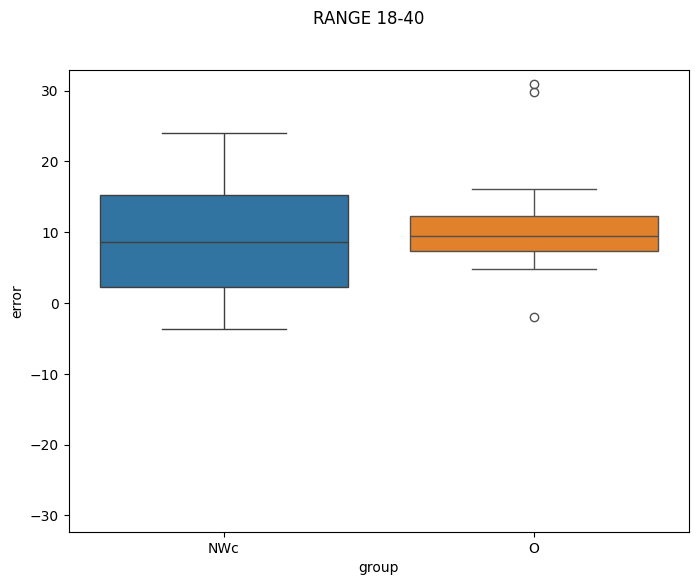

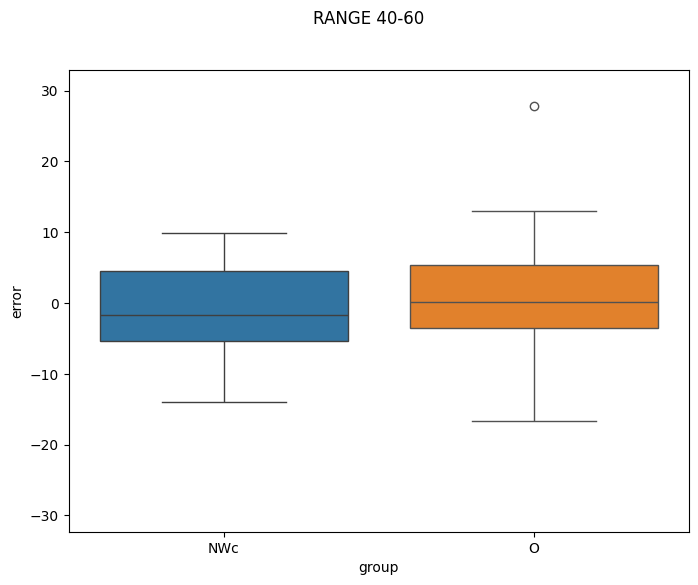

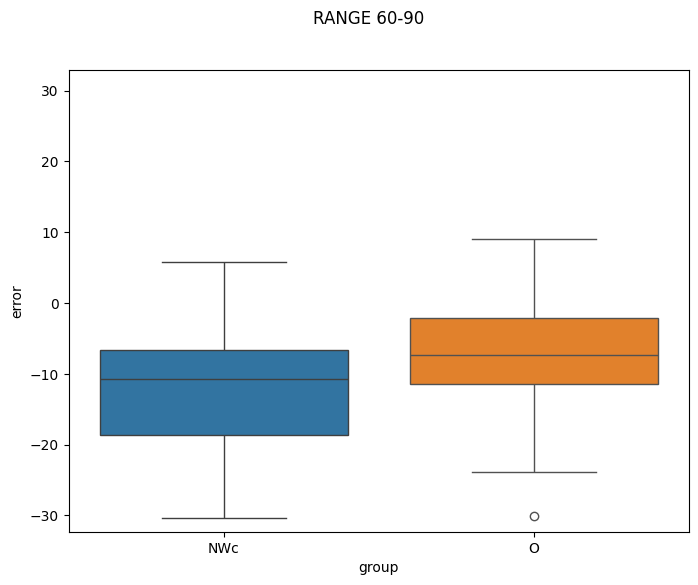

In [ ]:
fig11 = plt.figure(layout='constrained', figsize=(8, 6))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id] = plt.figure(figsize=(8, 6))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.boxplot(test_bin_df, x='group', y='error')
    sc2 = sns.boxplot(ob_bin, x='group', y='error')
    plt.ylim([np.min(np.concatenate((ob_df['error'], test_ss_df['error']))) - 2,
              np.max(np.concatenate((ob_df['error'], test_ss_df['error']))) + 2])

<Figure size 800x600 with 0 Axes>

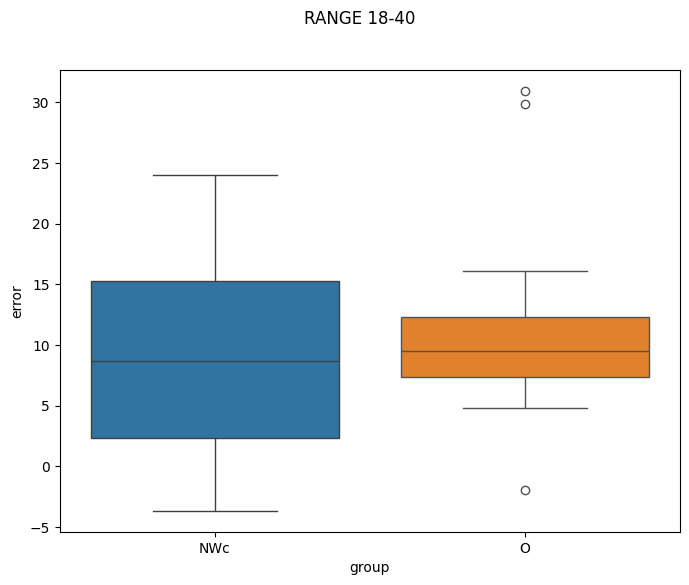

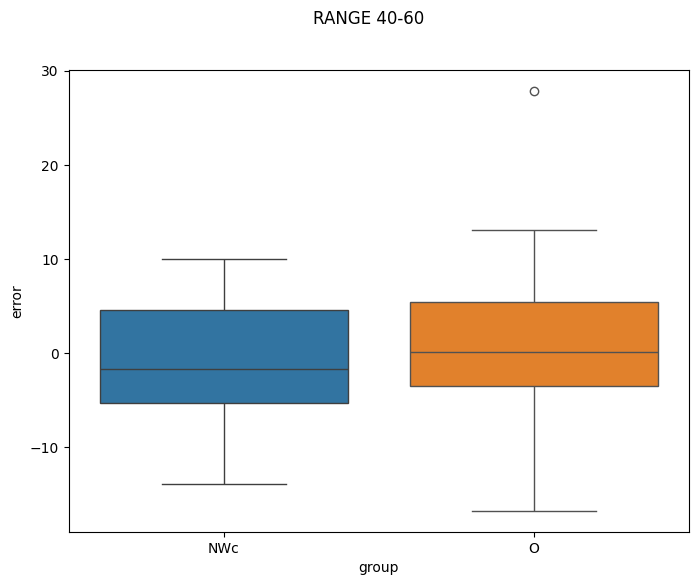

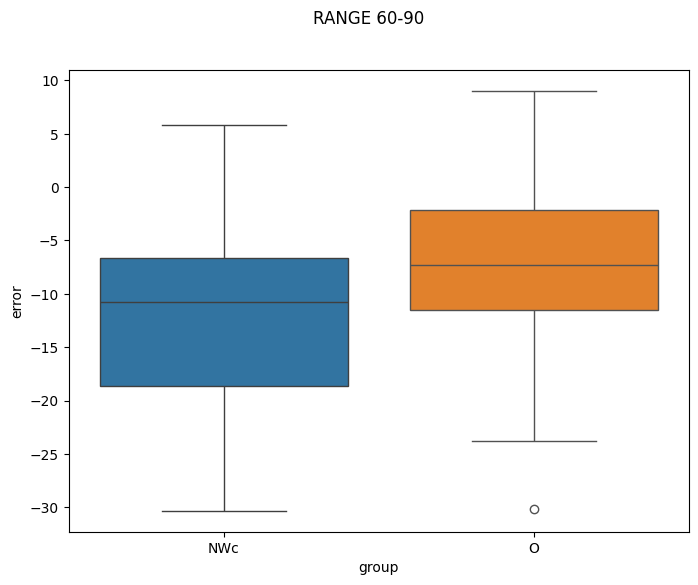

In [ ]:
fig11 = plt.figure(layout='constrained', figsize=(8, 6))
subfig = fig11.subfigures(len(bins) - 1, 1)
for bin_id in range(len(bins) - 1):
    subfig[bin_id] = plt.figure(figsize=(8, 6))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    ob_bin = ob_df[(bins[bin_id] <= ob_df['true age']) & (ob_df['true age'] < bins[bin_id + 1])]
    sc1 = sns.boxplot(test_bin_df, x='group', y='error')
    sc2 = sns.boxplot(ob_bin, x='group', y='error')
    #plt.ylim([np.min(np.concatenate((ob_df['error'], test_ss_df['error'])))-2, np.max(np.concatenate((ob_df['error'], test_ss_df['error'])))+2])

##CORRECTIONS (on residuals)


Predicted brain age (as well as brain age delta) typically shows overestimation in younger individuals and underestimation in older individuals. For this reason, it is important to Remove this age-bias to ensure that any further analyses are not influenced by the age-dependence of the predictions.

This correction is typically done by fitting a regression model on predicted age as a function of chronological age. The slope and intercept of the regression model are then used to compute the corrected predicted age, that is used to derive corrected delta values (i.e., corrected brain age delta = corrected predicted age – chronological age)

In [ ]:
figu2 = px.scatter(norm_ss_df, x='true age', y='error', labels={'x': 'true age', 'y': 'prediction error'},
                   trendline="ols", height=600, width=800)
figu2.show()

In [ ]:
b0, b1 = px.get_trendline_results(figu2).px_fit_results.iloc[0].params
print('intercept:', b0)
print('slope:', b1)

intercept: 16.774264780260474
slope: -0.32415981611294864


In [ ]:
test_df

test true age  prediction      error
10           19.17   43.165023  23.995023
40           27.00   43.218405  16.218405
3            25.25   27.846994   2.596994
96           37.67   41.488327   3.818327
55           37.33   37.720734   0.390734
..             ...         ...        ...
502          79.50   49.807868 -29.692132
525          83.75   69.328175 -14.421825
499          84.08   66.395839 -17.684161
485          82.58   59.971409 -22.608591
527          86.67   81.216518  -5.453482

[83 rows x 3 columns]

In [ ]:
test_ss_df.index

Index([ 10,  40,   3,  96,  55,  93, 100, 103, 126, 107, 149, 212, 195, 204,
       173, 203, 214, 175, 161, 274, 270, 225, 256, 251, 290, 269, 281, 235,
       292, 252, 289, 316, 359, 326, 337, 310, 349, 365, 332, 360, 374, 314,
       354, 357, 329, 347, 370, 308, 328, 436, 420, 386, 398, 391, 430, 425,
       459, 488, 444, 414, 531, 383, 400, 442, 450, 453, 421, 439, 403, 451,
       496, 487, 521, 429, 503, 476, 478, 522, 502, 525, 499, 485, 527],
      dtype='int64')

In [ ]:
corr_tr = norm_ss_df['prediction'] - (b1 * norm_ss_df['true age'] + b0)
corr_nw = test_df['prediction'] - (b1 * test_df['test true age'] + b0)
corr_ob = ob_predictions - (b1 * ob_age + b0)

In [ ]:
corr_err_tr = corr_tr - norm_ss_df['true age']
corr_err_ob = corr_ob - ob_age
corr_err_nw = corr_nw - test_df['test true age']
correction_train = pd.DataFrame({'true age': norm_ss_df['true age'], 'corr_pred': corr_tr, 'corr_res': corr_err_tr,
                                 'group': np.repeat('TR', len(norm_ss_df['true age']))})
correction_nw_df = pd.DataFrame({'true age': test_df['test true age'], 'corr_pred': corr_nw, 'corr_res': corr_err_nw,
                                 'group': np.repeat('NWc', len(test_df['test true age']))})
correction_ob_df = pd.DataFrame(
    {'true age': ob_age, 'corr_pred': corr_ob, 'corr_res': corr_err_ob, 'group': np.repeat('O', len(ob_age))})
tot_corr = pd.concat([correction_train, correction_nw_df, correction_ob_df])

In [ ]:
fig91 = px.scatter(tot_corr, x='true age', y='corr_pred', labels={'x': 'true age', 'y': 'corr_pred_error'},
                   trendline="ols", height=600, facet_col='group')
fig91.show()

In [ ]:
fig92 = px.scatter(tot_corr, x='true age', y='corr_pred', labels={'x': 'true age', 'y': 'corr_pred_error'}, height=600,
                   facet_col='group')
fig92.update_xaxes(showgrid=False)
fig92.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig92.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig92.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
trace = go.Scatter(x=[18, 90], y=[18, 90], mode='lines', line_color='red', name='optimal prediction')
trace.update(showlegend=False)
fig92.add_trace(trace, row='all', col='all')
fig92.show()

In [ ]:
fig93 = px.scatter(tot_corr, x='true age', y='corr_res', labels={'x': 'true age', 'y': 'corr_pred_error'},
                   trendline="ols", height=600, facet_col='group')
fig93.update_xaxes(showgrid=False)
fig93.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig93.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig93.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig93.show()

In [ ]:
corr_err_tr.shape

(361,)

####Statistics (Alternative method)

In [ ]:
corr_tr

0      22.461382
1      24.030632
2      29.372532
4      28.344947
5      31.618828
         ...    
518    82.207514
519    71.433581
520    89.234803
528    78.688738
532    75.967409
Length: 361, dtype: float64

In [ ]:
print('R2 TRAIN:', metrics.r2_score(norm_ss_df['true age'], corr_tr))
print('R2 NW:', metrics.r2_score(test_df['test true age'], corr_nw))
print('R2 OB:', metrics.r2_score(ob_age, corr_ob))

R2 TRAIN: 0.888089659187421
R2 NW: 0.7528019385220504
R2 OB: 0.7159955385314214


In [ ]:
print('MAE TR:', np.abs(corr_err_tr).mean())
print('MAE NW:', np.abs(corr_err_nw).mean())
print('MAE OB:', np.abs(corr_err_ob).mean())


MAE TR: 5.0280200086056075
MAE NW: 6.471363815956857
MAE OB: 6.649529786284112


In [ ]:
print('MEAN ERROR TR:', corr_err_tr.mean())
print('MEAN ERROR NW:', corr_err_nw.mean())
print('MEAN ERROR OB:', corr_err_ob.mean())

MEAN ERROR TR: 3.306680875559469e-15
MEAN ERROR NW: -2.8454907450713582
MEAN ERROR OB: 0.31762818816033805


In [ ]:
print('STD ERROR TR:', corr_err_tr.std())
print('STD ERROR NW:', corr_err_nw.std())
print('STD ERROR OB:', corr_err_ob.std())

STD ERROR TR: 6.190016971343776
STD ERROR NW: 7.626944505806816
STD ERROR OB: 8.656043208864167


In [ ]:
print('NW mean residuals:', round(corr_err_nw.mean(), 2), 'std', round(corr_err_nw.std(), 2))
print('O mean residuals:', round(corr_err_ob.mean(), 2), 'std:', round(corr_err_ob.std(), 2))
print('O-NW:', round(corr_err_ob.mean() - corr_err_nw.mean(), 2))

NW mean residuals: -2.85 std 7.63
O mean residuals: 0.32 std: 8.66
O-NW: 3.16


In [ ]:
print('NW mean residuals:', round(corr_err_nw.mean(), 2), 'std', round(corr_err_nw.std(), 2))
print('O mean residuals:', round(corr_err_ob.mean(), 2), 'std:', round(corr_err_ob.std(), 2))
print('O-NW:', round(corr_err_ob.mean() - corr_err_nw.mean(), 2))

NW mean residuals: -2.85 std 7.63
O mean residuals: 0.32 std: 8.66
O-NW: 3.16


In [ ]:
stats.ttest_ind(correction_ob_df['corr_res'], correction_nw_df['corr_res'], equal_var=False)

TtestResult(statistic=2.497870026049036, pvalue=0.01349575998016694, df=161.44107609913746)

In [ ]:
corr_err_nw

10     13.434902
40      8.196455
3      -5.992235
96     -0.744837
55     -4.282645
         ...    
502   -20.695691
525    -4.047705
499    -7.203069
485   -12.613738
527     5.867185
Length: 83, dtype: float64

In [ ]:
stats.ttest_ind(corr_err_ob, corr_err_nw, equal_var=False)

TtestResult(statistic=2.497870026049036, pvalue=0.01349575998016694, df=161.44107609913746)

In [ ]:
correction_ob_df

true age  corr_pred   corr_res group
23      19.00  38.222576  19.222576     O
37      26.83  25.995605  -0.834395     O
38      25.08  47.396121  22.316121     O
62      37.42  30.789969  -6.630031     O
66      35.58  39.807235   4.227235     O
..        ...        ...        ...   ...
515     79.42  68.927348 -10.492652     O
523     81.33  83.991465   2.661465     O
526     80.42  81.109628   0.689628     O
530     79.33  73.918488  -5.411512     O
534     86.08  67.055321 -19.024679     O

[83 rows x 4 columns]

In [ ]:
intervals = []
small_df = [correction_nw_df, correction_ob_df]
corr_dataf_means = [[], []]
corr_errors_df = [[], []]
corr_std_devs = [[], []]
for bin_id in range(len(bins) - 1):
    intervals.append(str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    for dfi in range(len(small_df)):
        dataf_bin = small_df[dfi]
        dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
        errors = dfi_bin['corr_res'].values
        corr_errors_df[dfi].append(errors)
        corr_dataf_means[dfi].append(errors.mean())
        corr_std_devs[dfi].append(errors.std())
print(intervals)
print(corr_dataf_means)
print(corr_std_devs)

['18-40', '40-60', '60-90']
[[2.922673869715981, -1.447804757470207, -4.816878367412803], [5.973097738054974, 0.9389427894426297, -1.3006366363529371]]
[[7.128243376338947, 5.294313794421288, 7.6641931195267885], [7.8472586620969595, 9.302264501717548, 7.829476222595581]]


In [ ]:
for bin_i in range(len(corr_errors_df[0])):
    print('\n#### BIN [', bins[bin_i], '-', bins[bin_i + 1], '] ####\n')
    print('####### t-test #######')
    ob_nw_tt = stats.ttest_ind(corr_errors_df[1][bin_i], corr_errors_df[0][bin_i], equal_var=False)
    print('norm test and obese (pvalue):', round(ob_nw_tt.pvalue, 3))
    print('norm test and obese (t):', round(ob_nw_tt.statistic, 3))
    print('NW: ', round(corr_dataf_means[0][bin_i], 2),
          '(' + u"\u00B1" + ' ' + str(round(corr_std_devs[0][bin_i], 2)) + ')')
    print('O: ', round(corr_dataf_means[1][bin_i], 2),
          '(' + u"\u00B1" + ' ' + str(round(corr_std_devs[1][bin_i], 2)) + ')')
    print('O-NW: ', round(corr_dataf_means[1][bin_i] - corr_dataf_means[0][bin_i], 2))


#### BIN [ 18 - 40 ] ####

####### t-test #######
norm test and obese (pvalue): 0.35
norm test and obese (t): 0.954
NW:  2.92 (± 7.13)
O:  5.97 (± 7.85)
O-NW:  3.05

#### BIN [ 40 - 60 ] ####

####### t-test #######
norm test and obese (pvalue): 0.326
norm test and obese (t): 0.997
NW:  -1.45 (± 5.29)
O:  0.94 (± 9.3)
O-NW:  2.39

#### BIN [ 60 - 90 ] ####

####### t-test #######
norm test and obese (pvalue): 0.027
norm test and obese (t): 2.247
NW:  -4.82 (± 7.66)
O:  -1.3 (± 7.83)
O-NW:  3.52


In [ ]:
age_range = []
for i in range(len(tot_corr)):
    if tot_corr.iloc[i]['true age'] < 40:
        age_range.append(0)
    if ((tot_corr.iloc[i]['true age'] < 60) & (tot_corr.iloc[i]['true age'] >= 40)):
        age_range.append(1)
    if tot_corr.iloc[i]['true age'] >= 60:
        age_range.append(2)

In [ ]:
tot_corr['age_group'] = age_range

In [ ]:
tot_corr

true age  corr_pred   corr_res group  age_group
0       24.50  22.461382  -2.038618    TR          0
1       28.67  24.030632  -4.639368    TR          0
2       23.33  29.372532   6.042532    TR          0
4       28.42  28.344947  -0.075053    TR          0
5       25.25  31.618828   6.368828    TR          0
..        ...        ...        ...   ...        ...
515     79.42  68.927348 -10.492652     O          2
523     81.33  83.991465   2.661465     O          2
526     80.42  81.109628   0.689628     O          2
530     79.33  73.918488  -5.411512     O          2
534     86.08  67.055321 -19.024679     O          2

[527 rows x 5 columns]

## Representations (entire datasets)

In [ ]:
fig6 = px.scatter(tot_std, x='true age', y='z_err', labels={'x': 'true age', 'y': 'z (prediction error)'},
                  trendline="ols", height=600, facet_col='group')
fig6.update_traces(selector=-1, showlegend=True)
fig6.update_xaxes(showgrid=False)
fig6.update_yaxes(showline=True, linecolor='black', showgrid=False)
fig6.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
)
fig6.for_each_yaxis(lambda yax: yax.update(showticklabels=True))
fig6.show()

Text(0.5, 0, 'Corrected Brain Age Delta')

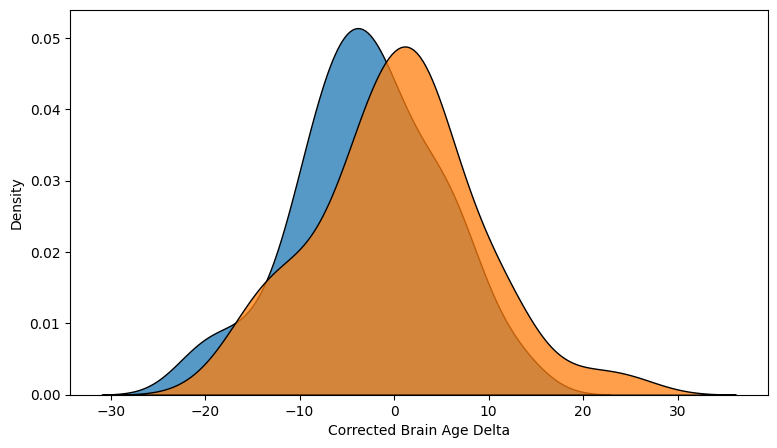

In [ ]:
fig_corr = plt.figure(figsize=(9, 5))
kd1 = sns.kdeplot(correction_nw_df, x='corr_res', multiple='stack', label='NW')
kd2 = sns.kdeplot(correction_ob_df, x='corr_res', multiple='stack', label='OB')
plt.xlabel('Corrected Brain Age Delta')

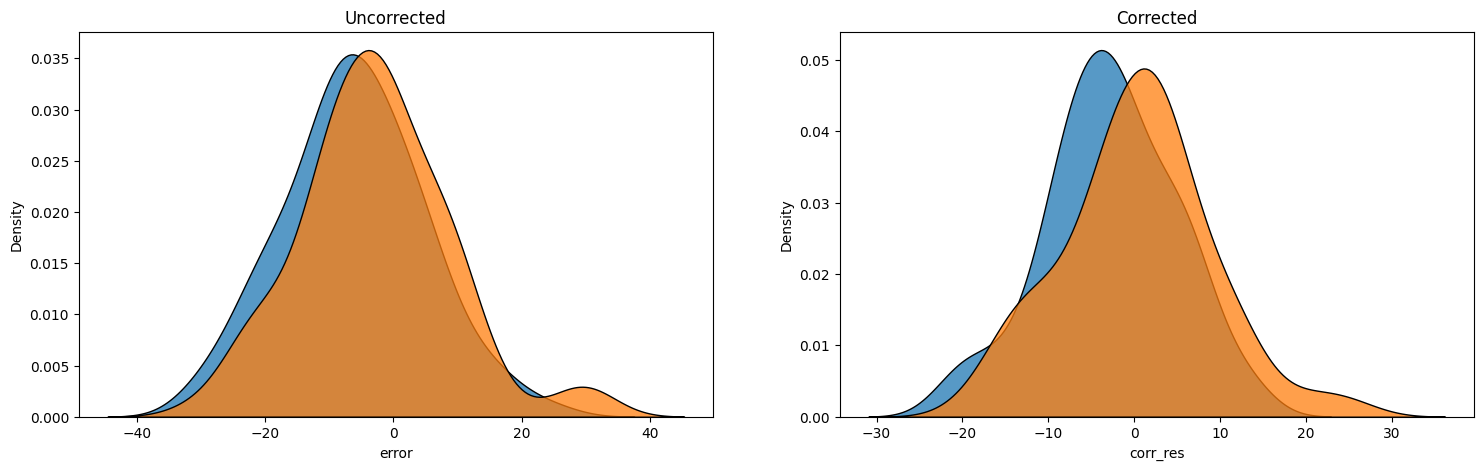

In [ ]:
fig10, axes = plt.subplots(ncols=2, figsize=(18, 5))
kd1 = sns.kdeplot(test_ss_df, x='error', multiple='stack', label='NW', ax=axes[0])
kd2 = sns.kdeplot(ob_df, x='error', multiple='stack', label='OB', ax=axes[0])
kd1 = sns.kdeplot(correction_nw_df, x='corr_res', multiple='stack', label='NW', ax=axes[1])
kd2 = sns.kdeplot(correction_ob_df, x='corr_res', multiple='stack', label='OB', ax=axes[1])
axes[0].title.set_text('Uncorrected')
axes[1].title.set_text('Corrected')

Text(0, 0.5, 'Corrected Brain Age Delta')

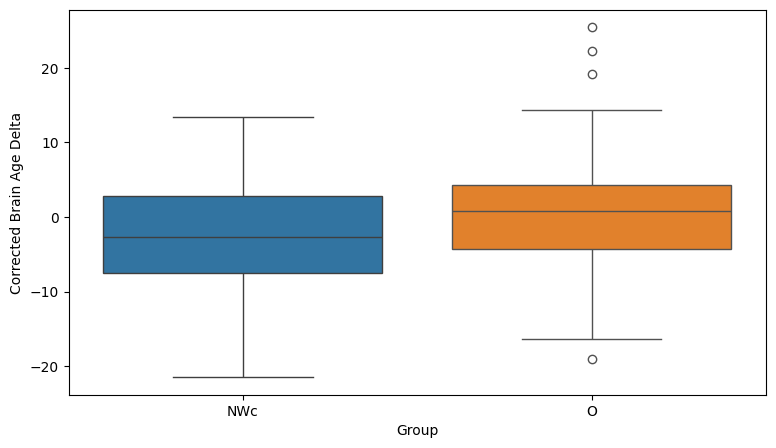

In [ ]:
fig_cor2 = plt.figure(figsize=(9, 5))
sns.boxplot(data=correction_nw_df, x='group', y='corr_res')
sns.boxplot(data=correction_ob_df, x='group', y='corr_res')
plt.xlabel('Group')
plt.ylabel('Corrected Brain Age Delta')

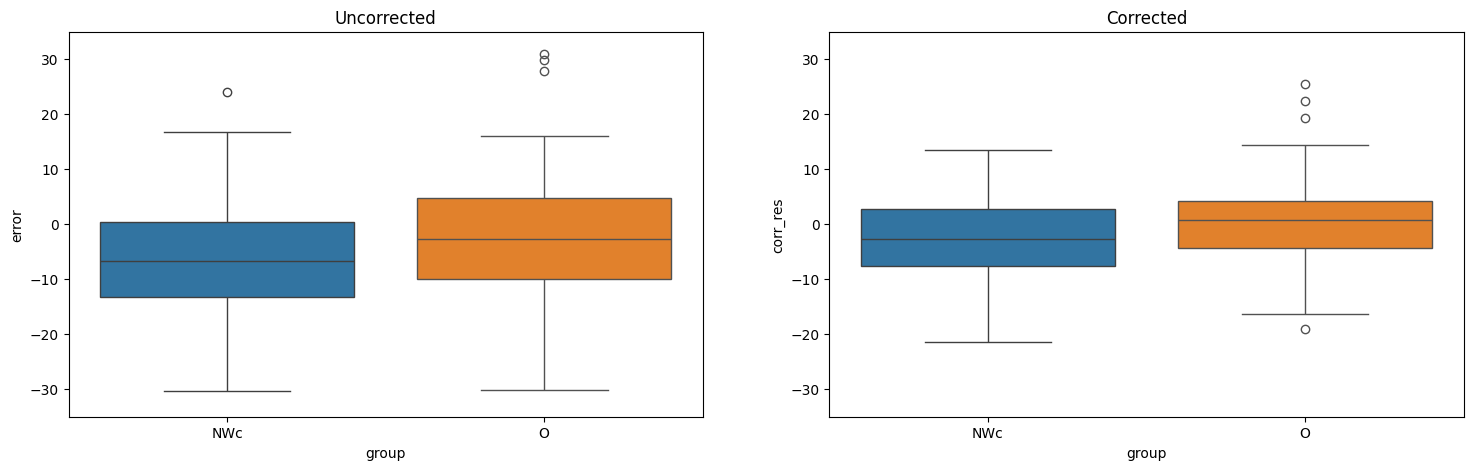

In [ ]:
fig11, axes = plt.subplots(ncols=2, figsize=(18, 5))
sns.boxplot(data=test_ss_df, x='group', y='error', ax=axes[0])
sns.boxplot(data=ob_df, x='group', y='error', ax=axes[0])
sns.boxplot(data=correction_nw_df, x='group', y='corr_res', ax=axes[1])
sns.boxplot(data=correction_ob_df, x='group', y='corr_res', ax=axes[1])
axes[0].set_ylim(-35, 35)
axes[1].set_ylim(-35, 35)
axes[0].title.set_text('Uncorrected')
axes[1].title.set_text('Corrected')

In [ ]:
bins = [18, 40, 60, 90]

<Figure size 1800x500 with 0 Axes>

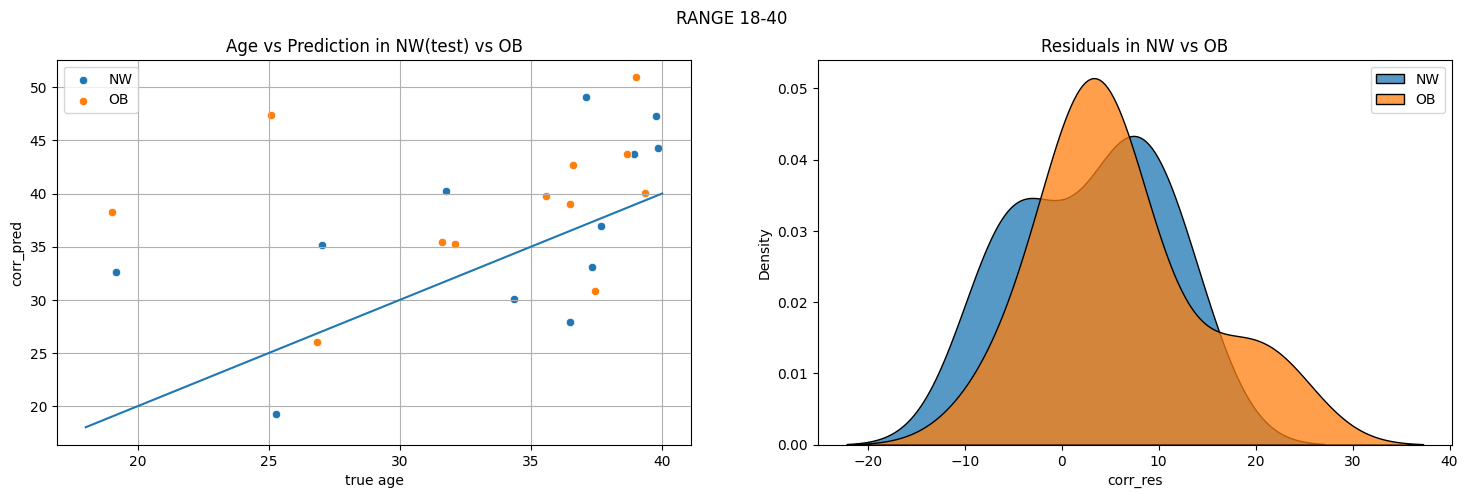

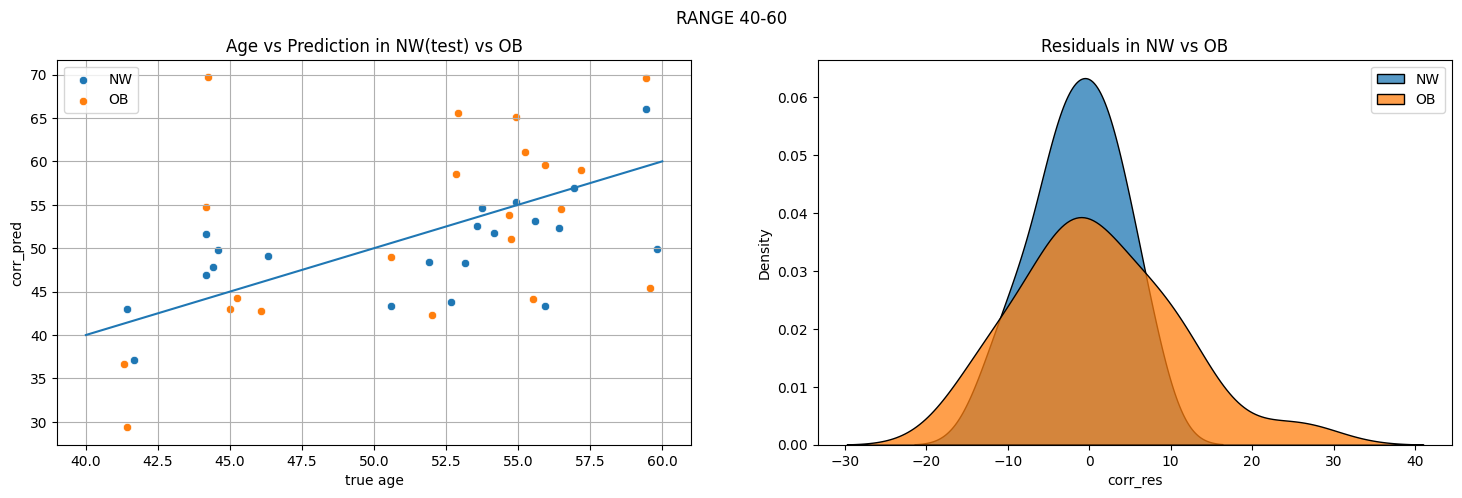

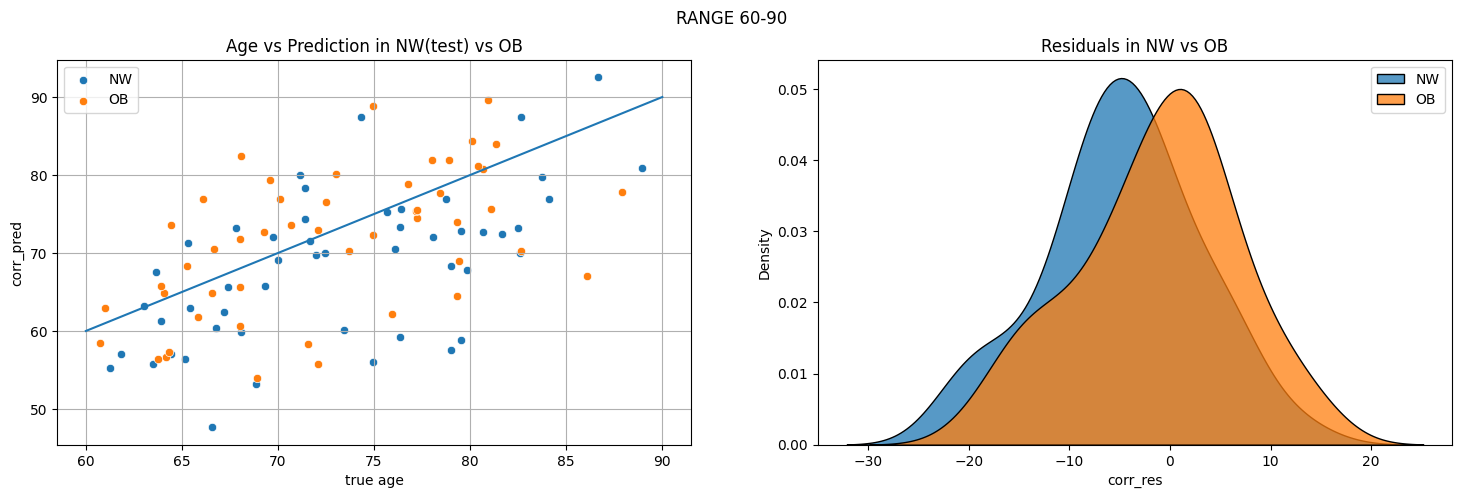

In [ ]:
fig11 = plt.figure(layout='constrained', figsize=(18, 5))
subfig = fig11.subfigures(len(bins) - 1, 1)
small_df = [correction_ob_df]
labels_df = ['OB']
for bin_id in range(len(bins) - 1):
    subfig[bin_id], axes = plt.subplots(ncols=2, figsize=(18, 5))
    subfig[bin_id].suptitle('RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    dataf_bin = small_df[0]
    test_bin_df = correction_nw_df[
        (bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
    sc1 = sns.scatterplot(test_bin_df, x='true age', y='corr_pred', ax=axes[0], label='NW')
    sc2 = sns.scatterplot(dfi_bin, x='true age', y='corr_pred', ax=axes[0], label=labels_df[0])
    sns.lineplot(x=[bins[bin_id], bins[bin_id + 1]], y=[bins[bin_id], bins[bin_id + 1]], ax=axes[0])
    kd1 = sns.kdeplot(test_bin_df, x='corr_res', ax=axes[1], multiple='stack', label='NW')
    kd2 = sns.kdeplot(dfi_bin, x='corr_res', ax=axes[1], multiple='stack', label=labels_df[0])
    axes[0].title.set_text('Age vs Prediction in NW(test) vs ' + labels_df[0])
    axes[1].title.set_text('Residuals in NW vs ' + labels_df[0])
    axes[0].legend()
    axes[1].legend()
    axes[0].grid()

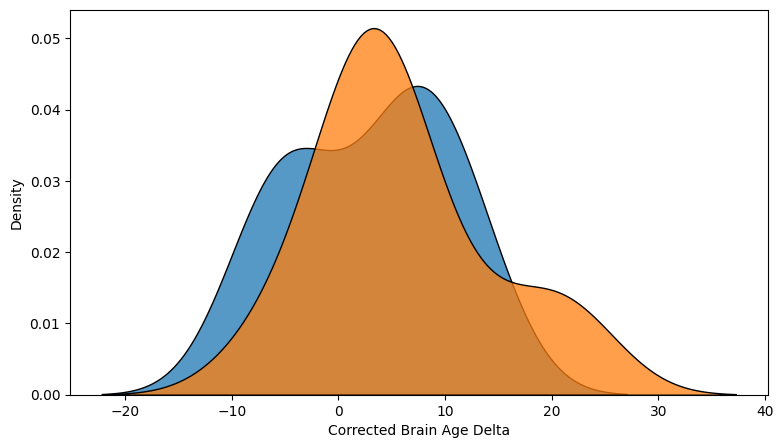

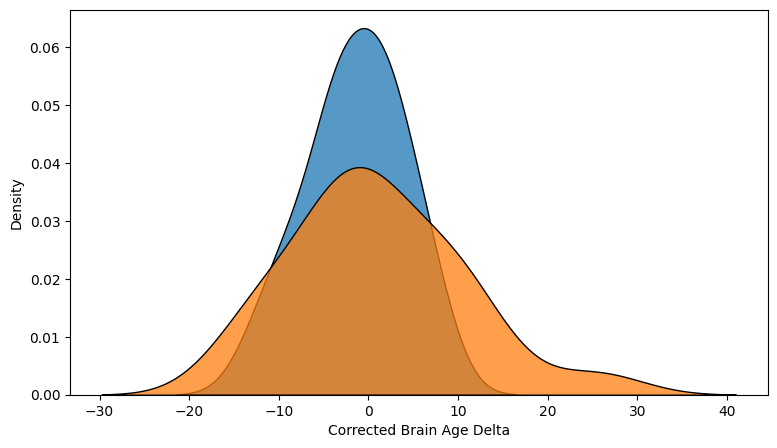

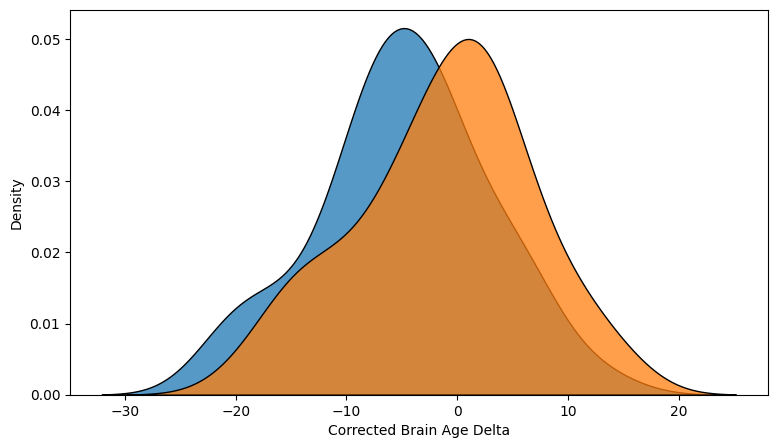

In [ ]:
for bin_id in range(len(bins) - 1):
    corr_fig3 = plt.figure(figsize=(9, 5))
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(corr_test_bin_df, x='corr_res', multiple='stack', label='NW')
    kd2 = sns.kdeplot(corr_ob_bin, x='corr_res', multiple='stack', label='O')
    plt.xlabel('Corrected Brain Age Delta')

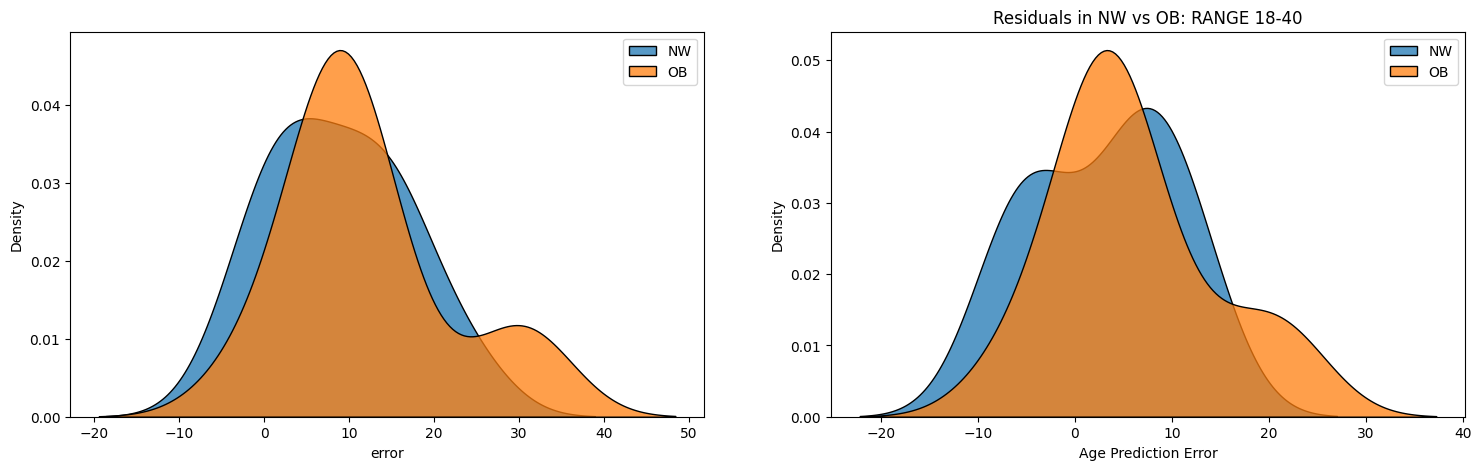

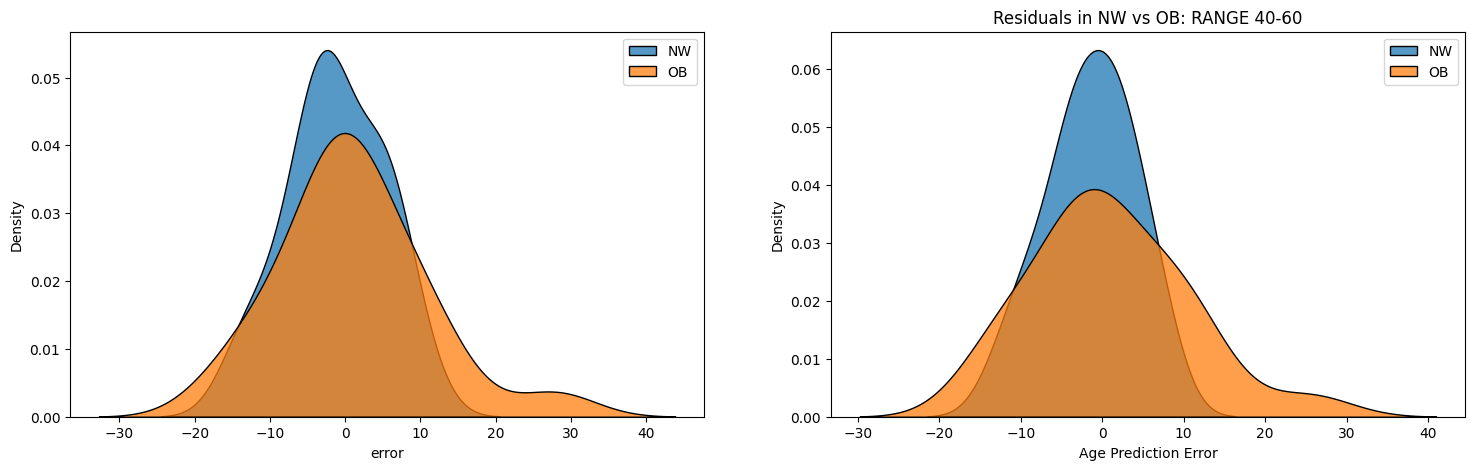

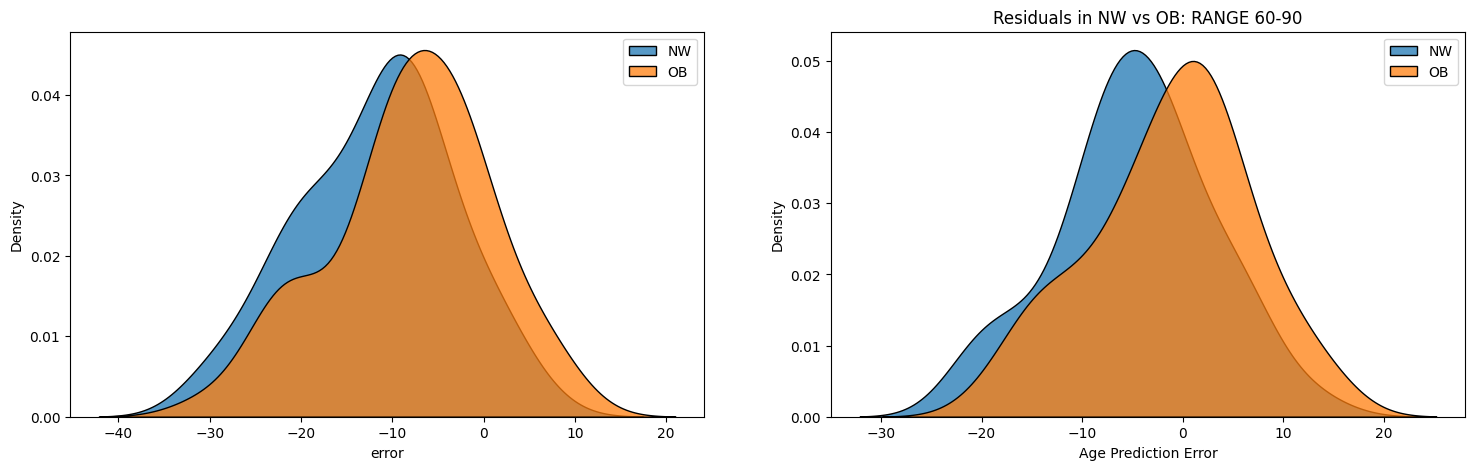

In [ ]:
small_df = [ob_df]
labels_df = ['OB']
for bin_id in range(len(bins) - 1):
    fig1, axes = plt.subplots(ncols=2, figsize=(18, 5))
    plt.title('Residuals in NW vs ' + labels_df[0] + ': RANGE ' + str(bins[bin_id]) + '-' + str(bins[bin_id + 1]))
    dataf_bin = small_df[0]
    test_bin_df = test_ss_df[(bins[bin_id] < test_ss_df['true age']) & (test_ss_df['true age'] < bins[bin_id + 1])]
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    dfi_bin = dataf_bin[(bins[bin_id] <= dataf_bin['true age']) & (dataf_bin['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.kdeplot(test_bin_df, x='error', multiple='stack', label='NW', ax=axes[0])
    kd2 = sns.kdeplot(dfi_bin, x='error', multiple='stack', label=labels_df[0], ax=axes[0])
    kd1 = sns.kdeplot(corr_test_bin_df, x='corr_res', multiple='stack', label='NW', ax=axes[1])
    kd2 = sns.kdeplot(corr_ob_bin, x='corr_res', multiple='stack', label=labels_df[0], ax=axes[1])
    plt.xlabel('Age Prediction Error')
    axes[0].legend()
    axes[1].legend()
    plt.show()

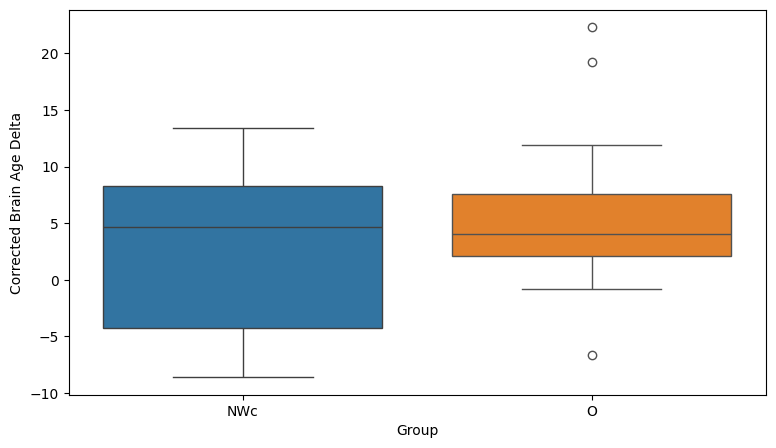

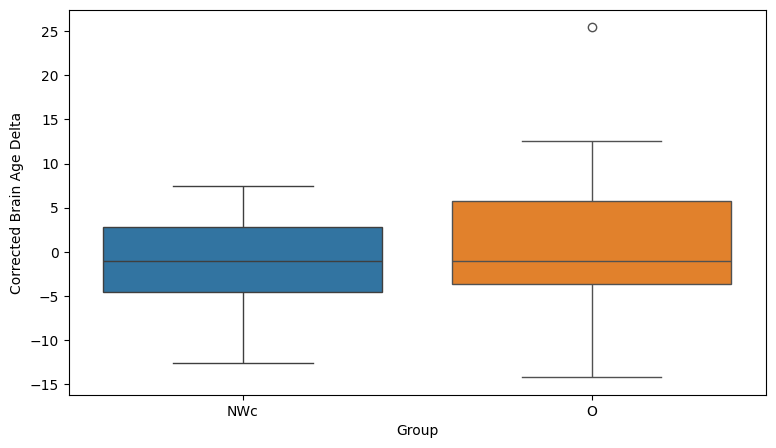

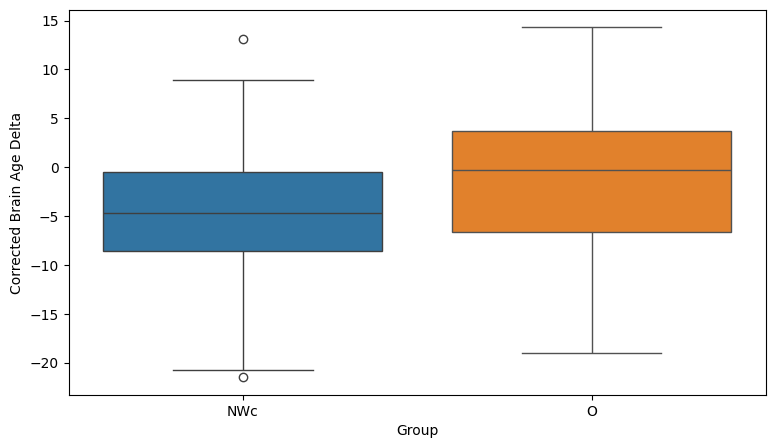

In [ ]:
for bin_id in range(len(bins) - 1):
    corr_fig3 = plt.figure(figsize=(9, 5))
    corr_test_bin_df = correction_nw_df[
        (bins[bin_id] < correction_nw_df['true age']) & (correction_nw_df['true age'] < bins[bin_id + 1])]
    corr_ob_bin = correction_ob_df[
        (bins[bin_id] <= correction_ob_df['true age']) & (correction_ob_df['true age'] < bins[bin_id + 1])]
    kd1 = sns.boxplot(corr_test_bin_df, x='group', y='corr_res')
    kd2 = sns.boxplot(corr_ob_bin, x='group', y='corr_res')
    plt.xlabel('Group')
    plt.ylabel('Corrected Brain Age Delta')

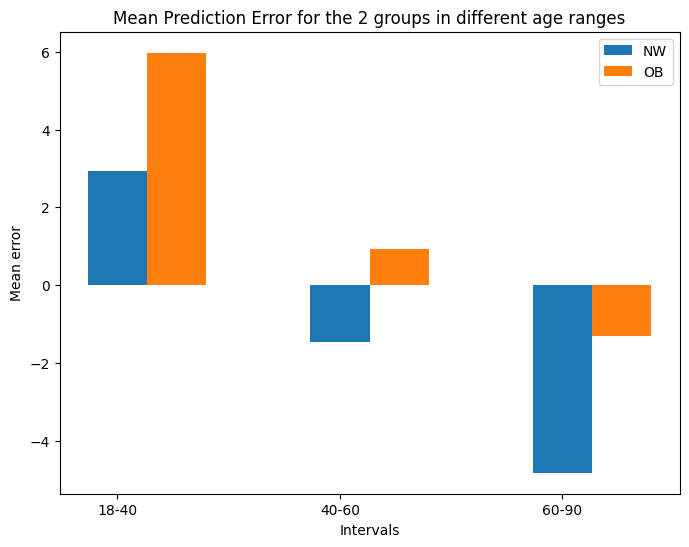

In [ ]:
barfig = plt.figure(figsize=(8, 6))
labels_df = ['NW', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    plt.bar(inter + lab * 0.8, corr_dataf_means[lab], label=labels_df[lab])
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

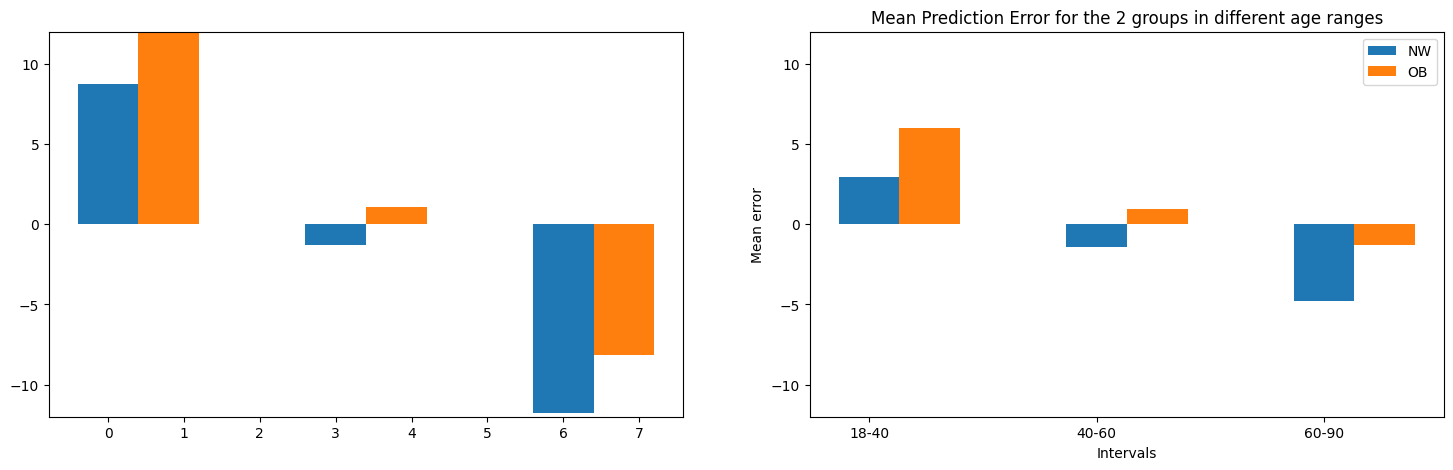

In [ ]:
barfig, axes = plt.subplots(ncols=2, figsize=(18, 5))
labels_df = ['NW', 'OB']
inter = np.arange(len(intervals)) * 3
for lab in range(len(labels_df)):
    axes[0].bar(inter + lab * 0.8, dataf_means[lab], label=labels_df[lab])
    axes[1].bar(inter + lab * 0.8, corr_dataf_means[lab], label=labels_df[lab])
axes[0].set_ylim(-12, 12)
axes[1].set_ylim(-12, 12)
plt.xticks(inter, intervals)
plt.xlabel("Intervals")
plt.ylabel("Mean error")
plt.title("Mean Prediction Error for the 2 groups in different age ranges")
plt.legend()
plt.show()

#Classification

MRI-derived measures yielding significant differences in age prediction error (both inter- and intra-connectivity) between O and NWc were also used to train models for classification of the obesity status.

In this second part, the number of PCs used for intra- and inter-connectivity corresponded to those explaining 95% of the variance in the training set. We used logistic regression as classifier, provided by the LogisticRegression class in scikit-learn.

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import metrics

In [ ]:
balanced = True  # True False
if balanced:
    norm_ob_index = np.concatenate((norm_test.index, obese_ss.index))
    print(norm_ob_index.shape)
else:
    norm_ob_index = np.concatenate((norm_weight_ss.index, obese_ss.index))
    print(norm_ob_index.shape)

(166,)


In [ ]:
norm_ob_data = data.loc[norm_ob_index]
norm_ob_label = norm_ob_data.Group
norm_ob_ages = norm_ob_data.Age.values
norm_ob_gender = norm_ob_data.Sex.values

In [ ]:
final_labels = []
for i in range(len(norm_ob_label)):
    if norm_ob_label.iloc[i] == 1:
        final_labels.append(0)
    else:
        final_labels.append(1)
final_labels = np.array(final_labels)

In [ ]:
data_used = type_data[1]  #1 = inter; 2 = intra
data_used.shape

(535, 12322)

Area under the curve (AUC), sensitivity (SE) and specificity (SP) were utilized to evaluate the predictive performance of the different models.

This was done using the following implemented function (calculate_metrics).

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

In [ ]:
def calculate_metrics(y_true, y_pred_prob):
    # Convert probabilities to binary predictions based on the threshold
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred_prob)
    difference_tpr_fpr = tpr - fpr  ##jouden j statistics is a statistic that captures the performance of a dichotomous diagnostic test
    optimal_threshold = threshold[np.argmax(difference_tpr_fpr)]
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)

    # Calculate AUC
    auc = metrics.auc(fpr, tpr)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

    # Compute sensitivity (TPR) and specificity (1 - FPR)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return auc, sensitivity, specificity

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
final_labels[norm_ob_ages < 40].shape

(24,)

In [ ]:
train_for_pca = data_used[norm_ob_index]
pca = PCA(n_components=.95, svd_solver='auto')  #95,90,85
encoded_samples_reduced_PCA = pca.fit_transform(train_for_pca)
print(encoded_samples_reduced_PCA.shape)

(166, 129)


 The dataset was split into 10 folds with a k-fold cross-validation scheme stratified by age. To ensure more stable results, this process was repeated 10 times using RepeatedStratifiedKFold function.

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
classifiers = ['XGBClassifier', 'Logistic Regression', 'SVC']
classifier = classifiers[1]
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
rskf.get_n_splits(encoded_samples_reduced_PCA, final_labels)
test_preds = np.full(encoded_samples_reduced_PCA.shape[0], np.nan)
results = []
model_coefficients = []
aucs_age_range = [[], [], []]
specificity_age_range = [[], [], []]
sensitivity_age_range = [[], [], []]
for i, (train_index, test_index) in enumerate(rskf.split(encoded_samples_reduced_PCA, final_labels)):
    print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    norm_ages = (norm_ob_ages - np.mean(norm_ob_ages[train_index])) / np.std(norm_ob_ages[train_index])
    norm_fmri_values = (encoded_samples_reduced_PCA - np.mean(encoded_samples_reduced_PCA[train_index])) / np.std(
        encoded_samples_reduced_PCA[train_index])
    x_class = np.array(
        [np.concatenate((norm_fmri_values[i, :], np.array([norm_ages[i]]), np.array([norm_ob_gender[i]]))) for i in
         range(norm_fmri_values.shape[0])])
    if classifier == 'Logistic Regression':
        #model = LogisticRegressionCV(cv=10, Cs=np.logspace(-4, 4, num=20), max_iter=2000, class_weight='balanced')
        model = LogisticRegression(max_iter=2000, class_weight='balanced')
        model = GridSearchCV(model, param_grid={'C': np.logspace(-4, 4, num=30),
                                                'tol': [3, 2, 1, 0.5, 0.05, 0.1, 0.01, 0.005, 0.001, 0.0001]},
                             # tol = [3, 2, 1, 0.5, 0.05, 0.005, 0.0001]
                             scoring='neg_log_loss', cv=10, error_score='raise')
        #model = LogisticRegression(
    elif classifier == 'XGBClassifier':
        model = XGBClassifier()  #scale_pos_weight = np.sum(np.array(final_labels)==0)/np.sum(np.array(final_labels)==1))
        model = GridSearchCV(model, param_grid={'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 3, 4, 5, 6, 7],
                                                'learning_rate': [0.05, 0.1, 0.3, 0.5]},
                             scoring='neg_log_loss', cv=10,
                             refit=True)  #scoring: neg_log_loss, n_est: [5,10,15], max_depth: [2,3,4,5,6,7]
    elif classifier == 'SVC':
        model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=10000)
        model = GridSearchCV(model, param_grid={'C': np.logspace(-4, 4, num=20), 'tol': [0.01, 0.001, 0.0001]},
                             scoring='neg_log_loss', cv=10)
    else:
        raise ValueError('Wrong classifier')

    model.fit(x_class[train_index], np.array(final_labels)[train_index])
    #model_Cs.append(model.C_)
    #coeffs.append(model.coef_)
    #model_parameters.append(model.get_params())
    test_preds[test_index] = model.predict_proba(x_class[test_index])[:, 1]
    if not np.isnan(test_preds).any():
        auc_0, sensitivity_0, specificity_0 = calculate_metrics(np.array(final_labels), test_preds)
        print('AUC:', auc_0)
        print('Sensitivity:', sensitivity_0)
        print('Specificity:', specificity_0)
        if classifier == 'XGBClassifier':
            print(model.best_params_)
        results.append({'AUC': auc_0,
                        'sensitivity': sensitivity_0,
                        'specificity': specificity_0,
                        'C': model.best_params_['C'],
                        'tol': model.best_params_['tol']
                        })
        model_coefficients.append(model.best_estimator_.coef_)
        age_ranges = [18, 40, 60, 90]
        for age_range_i in range(len(age_ranges) - 1):
            auc_1, sensitivity_1, specificity_1 = calculate_metrics(
                np.array(final_labels)[(norm_ob_ages >= age_ranges[age_range_i])
                                       & (norm_ob_ages < age_ranges[age_range_i + 1])],
                test_preds[(norm_ob_ages >= age_ranges[age_range_i]) & (norm_ob_ages < age_ranges[age_range_i + 1])])
            aucs_age_range[age_range_i].append(auc_1)
            sensitivity_age_range[age_range_i].append(sensitivity_1)
            specificity_age_range[age_range_i].append(specificity_1)
        test_preds = np.full(encoded_samples_reduced_PCA.shape[0], np.nan)

results = pd.DataFrame(results)
print(f'Mean AUC: {results.AUC.mean()}')
print(f'Mean sensitivity: {results.sensitivity.mean()}')
print(f'Mean specificity: {results.specificity.mean()}')

Fold 0:
  Test:  index=[  3  18  19  23  33  43  45  50  51  85  89  95  98 110 115 141 165]
Fold 1:
  Test:  index=[  1   7  10  37  48  59  61  69  74  87  93 108 118 126 136 154 156]
Fold 2:
  Test:  index=[  5  11  12  13  34  41  63  71  77 113 122 128 135 137 144 155 161]
Fold 3:
  Test:  index=[  4  32  39  47  64  66  76  79  91 109 116 125 133 139 147 160 164]
Fold 4:
  Test:  index=[ 15  22  24  42  49  58  65  81  90 102 106 131 145 150 151 162 163]
Fold 5:
  Test:  index=[  8  28  29  53  60  67  68  73  86  94 103 105 111 112 117 134 158]
Fold 6:
  Test:  index=[  0   6  14  20  27  38  40  72  88  97 100 121 123 142 148 157]
Fold 7:
  Test:  index=[ 16  21  25  26  36  46  52  56  84  96 104 119 132 143 149 152]
Fold 8:
  Test:  index=[ 31  35  44  55  57  70  78  80  83  92 120 124 140 146 153 159]
Fold 9:
  Test:  index=[  2   9  17  30  54  62  75  82  99 101 107 114 127 129 130 138]
AUC: 0.614312672376252
Sensitivity: 0.5662650602409639
Specificity: 0.6746987951807228

In [ ]:
results

AUC  sensitivity  specificity         C    tol
0  0.614313     0.566265     0.674699  0.016103  0.100
1  0.615038     0.433735     0.807229  0.008532  0.010
2  0.589636     0.481928     0.759036  0.057362  0.001
3  0.639715     0.530120     0.771084  0.016103  0.001
4  0.568152     0.325301     0.855422  0.016103  0.050
5  0.614748     0.433735     0.771084  0.016103  0.100
6  0.587313     0.698795     0.530120  0.016103  0.050
7  0.574829     0.638554     0.578313  0.008532  0.100
8  0.649586     0.518072     0.759036  0.008532  0.050
9  0.600813     0.457831     0.722892  0.008532  0.100

In [ ]:
print('C = (', round(results.C.mean(), 3), '±', round(results.C.std(), 3), ')')
print('tol = (', round(results.tol.mean(), 3), '±', round(results.tol.std(), 3), ')')

C = ( 0.017 ± 0.015 )
tol = ( 0.056 ± 0.042 )


In [ ]:
print('AUC mean:', results.AUC.mean())
print('AUC std', results.AUC.std())
print('Sensitivity mean:', results.sensitivity.mean())
print('Sensitivity std', results.sensitivity.std())
print('Specificity mean:', results.specificity.mean())
print('Specificity std', results.specificity.std())

AUC mean: 0.6054144287995356
AUC std 0.02647505837494776
Sensitivity mean: 0.5084337349397591
Sensitivity std 0.10803138203113202
Specificity mean: 0.7228915662650602
Specificity std 0.10128128685075094


In [ ]:
print('Mean AUC 18-40', np.array(aucs_age_range[0]).mean())
print('SD AUC 18_40', np.array(aucs_age_range[0]).std())
print('Mean AUC 40-60', np.array(aucs_age_range[1]).mean())
print('SD AUC 40-60', np.array(aucs_age_range[1]).std())
print('Mean AUC 60-90', np.array(aucs_age_range[2]).mean())
print('SD AUC 60-90', np.array(aucs_age_range[2]).std())

Mean AUC 18-40 0.5888888888888889
SD AUC 18_40 0.04378856325120679
Mean AUC 40-60 0.7360544217687075
SD AUC 40-60 0.04844547951008987
Mean AUC 60-90 0.5780399999999999
SD AUC 60-90 0.02344249133518021


In [ ]:
print('Mean specificity 18-40', np.array(specificity_age_range[0]).mean())
print('SD specificity 18-40', np.array(specificity_age_range[0]).std())
print('Mean specificity 40-60', np.array(specificity_age_range[1]).mean())
print('SD specificity 40-60', np.array(specificity_age_range[1]).std())
print('Mean specificity 60-90', np.array(specificity_age_range[2]).mean())
print('SD specificity 60-90', np.array(specificity_age_range[2]).std())

Mean specificity 18-40 0.7999999999999999
SD specificity 18-40 0.18708286933869706
Mean specificity 40-60 0.8095238095238095
SD specificity 40-60 0.12417528390862187
Mean specificity 60-90 0.704
SD specificity 60-90 0.0768374908491942


In [ ]:
print('Mean sensitivity 18-40', np.array(sensitivity_age_range[0]).mean())
print('SD sensitivity 18-40', np.array(sensitivity_age_range[0]).std())
print('Mean sensitivity 40-60', np.array(sensitivity_age_range[1]).mean())
print('SD sensitivity 40-60', np.array(sensitivity_age_range[1]).std())
print('Mean sensitivity 60-90', np.array(sensitivity_age_range[2]).mean())
print('SD sensitivity 60-90', np.array(sensitivity_age_range[2]).std())

Mean sensitivity 18-40 0.5
SD sensitivity 18-40 0.15811388300841897
Mean sensitivity 40-60 0.6523809523809525
SD sensitivity 40-60 0.08531653746270912
Mean sensitivity 60-90 0.534
SD sensitivity 60-90 0.09635351576356722


In [ ]:
results

AUC  sensitivity  specificity         C    tol
0  0.614313     0.566265     0.674699  0.016103  0.100
1  0.615038     0.433735     0.807229  0.008532  0.010
2  0.589636     0.481928     0.759036  0.057362  0.001
3  0.639715     0.530120     0.771084  0.016103  0.001
4  0.568152     0.325301     0.855422  0.016103  0.050
5  0.614748     0.433735     0.771084  0.016103  0.100
6  0.587313     0.698795     0.530120  0.016103  0.050
7  0.574829     0.638554     0.578313  0.008532  0.100
8  0.649586     0.518072     0.759036  0.008532  0.050
9  0.600813     0.457831     0.722892  0.008532  0.100

In [ ]:
results.C.mean()

0.0172001340579225